# This Jupyter Notebook provides a complete, executable pipeline for IoT data segmentation with the following improvements:

### Key Features:
1. **Interactive Execution**: Each major task can be run and tested independently
2. **Inline Visualization**: All plots are displayed directly in the notebook
3. **Progress Indicators**: Clear emoji-based progress indicators
4. **Immediate Feedback**: Output after each cell execution
5. **Sample Data Display**: Preview of data at each stage
6. **Error Handling**: Graceful error handling with detailed messages

### Usage:
1. Run cells sequentially from top to bottom
2. Each major task (Data Loading, Feature Engineering, Segmentation) has its own test cell
3. Visualizations appear inline after each relevant cell
4. The complete pipeline can be run with the final cell
5. Results are saved to disk but also analyzed inline

### Outputs:
- **Inline Plots**: Displayed after each visualization cell
- **Console Output**: Progress and metrics shown in notebook output
- **Saved Files**: Results saved to `segmentation_output/` directory
- **Final Summary**: Comprehensive analysis at the end

In [1]:
# Jupyter Notebook: Industrial IoT Data Segmentation Pipeline
# This notebook implements ClaSP for unsupervised segmentation of industrial IoT sensor data

# Import all required libraries
import json
import pandas as pd
import numpy as np
from pathlib import Path
from typing import Dict, List, Tuple, Optional
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Segmentation libraries
try:
    from claspy.segmentation import ClaSPEnsemble, BinaryClaSPSegmentation
except ImportError:
    try:
        from claspy import ClaSPEnsemble, BinaryClaSPSegmentation
    except ImportError:
        print("Warning: claspy not found. Install with: pip install claspy==0.2.7")
        ClaSPEnsemble = None
        BinaryClaSPSegmentation = None

try:
    import ruptures as rpt
except ImportError:
    print("Warning: ruptures not found. Install with: pip install ruptures")
    rpt = None

from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# For Jupyter display
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

In [2]:
# ============================================================================
# TASK 1: DATA LOADING & EXPLORATION
# ============================================================================

class IoTDataLoader:
    """Load and preprocess IoT JSONL files with mixed station data."""
    
    def __init__(self, data_dir: str = "data/data-radiant-eval-paper/factory/evaluation/iot_logs"):
        self.data_dir = Path(data_dir)
        self.raw_data = None
        self.processed_data = None
        self.station_data = {}
        
    def load_all_files(self, file_pattern: str = "*.jsonl") -> pd.DataFrame:
        """
        Load all JSONL files from data directory.
        
        Returns:
            Unified DataFrame with all records
        """
        jsonl_files = sorted(self.data_dir.glob(file_pattern))
        
        if not jsonl_files:
            raise FileNotFoundError(f"No JSONL files found in {self.data_dir}")
        
        print(f" Loading {len(jsonl_files)} JSONL files...")
        
        all_records = []
        for file_path in jsonl_files:
            print(f"   Loading {file_path.name}...")
            with open(file_path, 'r', encoding='utf-8') as f:
                for line_num, line in enumerate(f, 1):
                    try:
                        record = json.loads(line.strip())
                        record['source_file'] = file_path.name
                        all_records.append(record)
                    except json.JSONDecodeError as e:
                        print(f"Warning: Skipping invalid JSON at line {line_num} in {file_path.name}: {e}")
        
        self.raw_data = pd.DataFrame(all_records)
        print(f" Loaded {len(self.raw_data)} total records")
        
        return self.raw_data
    
    def parse_timestamps(self, df: pd.DataFrame) -> pd.DataFrame:
        """Parse timestamp strings to datetime objects."""
        if 'timestamp' in df.columns:
            df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')
            # Sort by timestamp for temporal analysis
            #df = df.sort_values('timestamp').reset_index(drop=True)
        return df
    
    def handle_mixed_types(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Convert string numbers to numeric types.
        Handles fields like "0.00" that should be numeric.
        """
        df = df.copy()
        
        for col in df.columns:
            if col in ['id', 'station', 'timestamp', 'current_state', 'current_task', 
                      'current_sub_task', 'source_file', 'hbw1_current_stock']:
                continue
            
            # Try to convert to numeric
            if df[col].dtype == 'object':
                # Check if values are numeric strings
                sample = df[col].dropna().head(10)
                if len(sample) > 0:
                    try:
                        # Try converting first non-null value
                        test_val = sample.iloc[0]
                        if isinstance(test_val, str) and test_val.replace('.', '').replace('-', '').isdigit():
                            df[col] = pd.to_numeric(df[col], errors='coerce')
                    except:
                        pass
        
        return df
    
    def expand_nested_structures(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Expand nested JSON structures (e.g., hbw1_current_stock).
        For now, we'll extract key information or flatten if needed.
        """
        df = df.copy()
        
        # Handle hbw1_current_stock nested structure
        if 'hbw1_current_stock' in df.columns:
            # Count non-empty stock positions
            def count_stock_items(stock_dict):
                if isinstance(stock_dict, dict):
                    return sum(1 for v in stock_dict.values() if v and str(v).strip())
                return 0
            
            df['hbw1_stock_count'] = df['hbw1_current_stock'].apply(count_stock_items)
            # Drop the nested column for now (can be expanded later if needed)
            df = df.drop(columns=['hbw1_current_stock'], errors='ignore')
        
        return df
    
    def split_by_station(self, df: pd.DataFrame) -> Dict[str, pd.DataFrame]:
        """
        Split unified DataFrame by station for individual analysis.
        
        Returns:
            Dictionary mapping station names to DataFrames
        """
        if 'station' not in df.columns:
            raise ValueError("DataFrame must have 'station' column")
        
        station_data = {}
        for station in df['station'].unique():
            station_df = df[df['station'] == station].copy()
            station_df = station_df.sort_values('timestamp').reset_index(drop=True)
            station_data[station] = station_df
            print(f"   Station {station}: {len(station_df)} records")
        
        self.station_data = station_data
        return station_data
    
    def get_diagnostics(self, df: pd.DataFrame) -> Dict:
        """
        Provide basic diagnostics: time ranges, missing values, sensor distributions.
        
        Returns:
            Dictionary with diagnostic information
        """
        diagnostics = {
            'total_records': len(df),
            'stations': df['station'].value_counts().to_dict() if 'station' in df.columns else {},
            'time_range': {},
            'missing_values': {},
            'sensor_info': {}
        }
        
        # Time range per station
        if 'timestamp' in df.columns and 'station' in df.columns:
            for station in df['station'].unique():
                station_df = df[df['station'] == station]
                if not station_df['timestamp'].isna().all():
                    diagnostics['time_range'][station] = {
                        'start': station_df['timestamp'].min(),
                        'end': station_df['timestamp'].max(),
                        'duration_hours': (station_df['timestamp'].max() - station_df['timestamp'].min()).total_seconds() / 3600
                    }
        
        # Missing values
        sensor_cols = [col for col in df.columns if col not in 
                      ['id', 'station', 'timestamp', 'current_state', 'current_task', 
                       'current_sub_task', 'source_file', 'hbw1_current_stock']]
        
        for col in sensor_cols:
            missing_count = df[col].isna().sum()
            if missing_count > 0:
                diagnostics['missing_values'][col] = {
                    'count': int(missing_count),
                    'percentage': float(missing_count / len(df) * 100)
                }
        
        # Sensor distributions (basic stats)
        for col in sensor_cols:
            if df[col].dtype in ['int64', 'float64']:
                diagnostics['sensor_info'][col] = {
                    'dtype': str(df[col].dtype),
                    'min': float(df[col].min()) if not df[col].isna().all() else None,
                    'max': float(df[col].max()) if not df[col].isna().all() else None,
                    'mean': float(df[col].mean()) if not df[col].isna().all() else None,
                    'unique_values': int(df[col].nunique())
                }
        
        return diagnostics
    
    def process_all(self) -> pd.DataFrame:
        """Complete data loading and preprocessing pipeline."""
        print("=" * 60)
        print("TASK 1: DATA LOADING & EXPLORATION")
        print("=" * 60)
        
        # Load files
        df = self.load_all_files()
        
        # Parse timestamps
        print("\n Parsing timestamps...")
        df = self.parse_timestamps(df)
        
        # Handle mixed types
        print(" Handling mixed numeric types...")
        df = self.handle_mixed_types(df)
        
        # Expand nested structures
        print(" Expanding nested structures...")
        df = self.expand_nested_structures(df)
        
        # Split by station
        print("\n Splitting data by station...")
        self.split_by_station(df)
        
        # Diagnostics
        print("\n Generating diagnostics...")
        diagnostics = self.get_diagnostics(df)
        
        print("\n" + "=" * 60)
        print("DIAGNOSTICS SUMMARY")
        print("=" * 60)
        print(f" Total records: {diagnostics['total_records']}")
        print(f"\n Stations: {list(diagnostics['stations'].keys())}")
        for station, count in diagnostics['stations'].items():
            print(f"  {station}: {count} records")
        
        print(f"\n Time ranges:")
        for station, tr in diagnostics['time_range'].items():
            print(f"  {station}:")
            print(f"    Start: {tr['start']}")
            print(f"    End: {tr['end']}")
            print(f"    Duration: {tr['duration_hours']:.2f} hours")
        
        if diagnostics['missing_values']:
            print(f"\n Missing values (top 10):")
            sorted_missing = sorted(diagnostics['missing_values'].items(), 
                                  key=lambda x: x[1]['count'], reverse=True)[:10]
            for col, info in sorted_missing:
                print(f"  {col}: {info['count']} ({info['percentage']:.2f}%)")
        else:
            print("\n No missing values detected in sensor columns.")
        
        self.processed_data = df
        return df

In [3]:
# Let's test Task 1
print("Testing Data Loading...")
loader = IoTDataLoader(data_dir="data/data-radiant-eval-paper/factory/evaluation/iot_logs")
df = loader.process_all()

# Display some sample data
print("\n" + "=" * 60)
print("SAMPLE DATA PREVIEW")
print("=" * 60)
print(f"DataFrame shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst 5 rows:")
display(df.head())

# Show station distribution
print("\n" + "=" * 60)
print("STATION DISTRIBUTION")
print("=" * 60)
for station, station_df in loader.station_data.items():
    print(f"{station}: {len(station_df)} records ({len(station_df)/len(df)*100:.1f}%)")

Testing Data Loading...
TASK 1: DATA LOADING & EXPLORATION
 Loading 5 JSONL files...
   Loading 1.jsonl...
   Loading 2.jsonl...
   Loading 3.jsonl...
   Loading 4.jsonl...
   Loading 5.jsonl...
 Loaded 38479 total records

 Parsing timestamps...
 Handling mixed numeric types...
 Expanding nested structures...

 Splitting data by station...
   Station MM_1: 5502 records
   Station HBW_1: 5482 records
   Station EC_1: 5503 records
   Station SM_1: 5499 records
   Station VGR_1: 5492 records
   Station OV_1: 5500 records
   Station WT_1: 5501 records

 Generating diagnostics...

DIAGNOSTICS SUMMARY
 Total records: 38479

 Stations: ['EC_1', 'MM_1', 'WT_1', 'OV_1', 'SM_1', 'VGR_1', 'HBW_1']
  EC_1: 5503 records
  MM_1: 5502 records
  WT_1: 5501 records
  OV_1: 5500 records
  SM_1: 5499 records
  VGR_1: 5492 records
  HBW_1: 5482 records

 Time ranges:
  MM_1:
    Start: 2023-01-30 13:06:20.230000
    End: 2023-03-20 11:10:51.940000
    Duration: 1174.08 hours
  HBW_1:
    Start: 2023-01-3

,id,station,timestamp,mm1_i1_pos_switch,mm1_i2_pos_switch,mm1_i3_pos_switch,mm1_i4_light_barrier,mm1_m1_speed,mm1_m2_speed,mm1_m3_speed,...,ov1_o8_compressor,ov1_failure_label,wt1_i3_pos_switch,wt1_i4_pos_switch,wt1_m2_speed,wt1_o5_valve,wt1_o6_valve,wt1_o8_compressor,wt1_failure_label,hbw1_stock_count
0,530fd0fb-6183-49c3-bb9e-18f24c61f217,MM_1,2023-01-30 13:06:20.230,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,adf0b290-9763-46ba-a04a-aa64abfea53f,HBW_1,2023-01-30 13:06:20.240,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,31eb5fbf-1a63-4c34-8192-6decb15c16d9,EC_1,2023-01-30 13:06:20.270,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,b9b9969c-f86a-4d6f-950e-915b773fd363,SM_1,2023-01-30 13:06:20.270,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,ccd4a5ea-70d2-47a8-be83-06d87ab193fa,VGR_1,2023-01-30 13:06:20.820,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0



STATION DISTRIBUTION
MM_1: 5502 records (14.3%)
HBW_1: 5482 records (14.2%)
EC_1: 5503 records (14.3%)
SM_1: 5499 records (14.3%)
VGR_1: 5492 records (14.3%)
OV_1: 5500 records (14.3%)
WT_1: 5501 records (14.3%)


In [4]:
# ============================================================================
# TASK 2: FEATURE ENGINEERING & STANDARDIZATION
# ============================================================================

class FeatureEngineer:
    """Feature engineering for station-specific sensor data."""
    
    def __init__(self):
        self.scalers = {}
        self.feature_configs = {}
    
    def get_station_sensors(self, df: pd.DataFrame, station: str) -> List[str]:
        """Extract station-specific sensor column names."""
        station_prefix = station.lower().replace('_', '')
        sensor_cols = []
        
        for col in df.columns:
            # Skip metadata columns
            if col in ['id', 'station', 'timestamp', 'current_state', 'current_task',
                      'current_sub_task', 'source_file', 'hbw1_current_stock']:
                continue
            
            # Check if column belongs to this station
            col_lower = col.lower()
            if col_lower.startswith(station_prefix) or col_lower.startswith(station_prefix[:3]):
                sensor_cols.append(col)
        
        return sensor_cols
    
    def classify_sensor_type(self, df: pd.DataFrame, col: str) -> str:
        """
        Classify sensor as binary, continuous, or position.
        
        Returns:
            'binary', 'continuous', 'position', or 'other'
        """
        if df[col].isna().all():
            return 'other'
        
        unique_vals = df[col].dropna().unique()
        n_unique = len(unique_vals)
        
        # Binary sensors (0/1 or True/False)
        if n_unique <= 2 and all(v in [0, 1, True, False, 0.0, 1.0] for v in unique_vals):
            return 'binary'
        
        # Position coordinates
        if 'pos' in col.lower() and ('x' in col.lower() or 'y' in col.lower() or 'z' in col.lower()):
            return 'position'
        
        # Continuous sensors (speeds, photoresistor, color sensors, etc.)
        return 'continuous'
    
    def create_temporal_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Create temporal features: time since last event, rate of change.
        """
        df = df.copy()
        df = df.sort_values('timestamp').reset_index(drop=True)
        
        # Time since last event (in seconds)
        if 'timestamp' in df.columns:
            df['time_since_last'] = df['timestamp'].diff().dt.total_seconds().fillna(0)
            df['time_since_last'] = df['time_since_last'].clip(upper=3600)  # Cap at 1 hour
        
        return df
    def build_position_features(self, values):
      vel = np.diff(values, prepend=values[0])
      threshold = np.percentile(np.abs(vel), 10)
      vel[np.abs(vel) < threshold] = 0
      motion = np.abs(vel)
      scale = np.percentile(motion, 95)
      if scale > 0:
        motion = motion / scale

      return np.clip(motion, 0, 1)


    def aggregate_signals(self, df: pd.DataFrame, sensor_cols: List[str],
                         station: str) -> pd.Series:
        """
        Create 1D aggregated signal for segmentation.
        
        Strategy:
        - Binary sensors: Keep as 0/1, use mean
        - Continuous sensors: Normalize and use mean
        - Position sensors: Use distance from origin or change detection
        
        Returns:
            1D time series for segmentation
        """
        if len(sensor_cols) == 0:
            raise ValueError(f"No sensor columns found for station {station}")
        
        # Classify sensors
        sensor_types = {col: self.classify_sensor_type(df, col) for col in sensor_cols}
        
        # Prepare normalized features
        normalized_features = []
        feature_weights = []
        for col in sensor_cols:
            if df[col].isna().all():
                continue
            
            sensor_type = sensor_types[col]
            values = df[col].fillna(0).values
            
            if sensor_type == 'binary':
                # Binary sensors: keep as 0/1
                stable_binary = (
                    pd.Series(values)
                    .rolling(3, min_periods=1)
                    .mean()
                    .fillna(0)
                    .values
                )
                normalized_features.append(stable_binary)
                feature_weights.append(1.0)


            elif sensor_type == 'continuous':
                # Continuous sensors: normalize to [0, 1]
                '''if values.max() > values.min():
                    normalized = (values - values.min()) / (values.max() - values.min())
                else:
                    normalized = values'''
                rng = values.max() - values.min()
                normalized = (values - values.min()) / rng if rng > 0 else np.zeros_like(values)
                normalized_features.append(normalized)
                feature_weights.append(1.0)


            elif sensor_type == 'position':
                # Position sensors: use absolute value or distance
                # For simplicity, use absolute value normalized
                motion_feature = self.build_position_features(values)
                '''if abs_values.max() > abs_values.min():
                    normalized = (abs_values - abs_values.min()) / (abs_values.max() - abs_values.min())
                else:
                    normalized = abs_values'''
                normalized_features.append(motion_feature)
                feature_weights.append(1.0)

        if len(normalized_features) == 0:
            # Fallback: use all numeric columns
            numeric_cols = df[sensor_cols].select_dtypes(include=[np.number]).columns
            if len(numeric_cols) > 0:
                for col in numeric_cols:
                    values = df[col].fillna(0).values
                    if values.max() > values.min():
                        normalized = (values - values.min()) / (values.max() - values.min())
                    else:
                        normalized = values
                    normalized_features.append(normalized)
            else:
                raise ValueError(f"No valid sensor data for station {station}")
        
        if len(normalized_features) == 0:
            raise ValueError(f"No valid normalized features for station {station}")
        
        # Aggregate: mean of normalized features
        aggregated = np.average(normalized_features, axis=0, weights=feature_weights)
        #aggregated = np.mean(normalized_features, axis=0)

        # Ensure no NaN or Inf values
        #aggregated = np.nan_to_num(aggregated, nan=0.0, posinf=1.0, neginf=0.0)
        aggregated = pd.Series(aggregated, index=df.index)
        aggregated = (
            aggregated
            .rolling(3, min_periods=1)
            .mean()
            .fillna(0)
            .replace([np.inf, -np.inf], 0)
        )


        


        return aggregated#pd.Series(aggregated, index=df.index)

    def engineer_features(self, df: pd.DataFrame, station: str) -> Tuple[pd.DataFrame, pd.Series]:
        """
        Complete feature engineering for a station.
        
        Returns:
            (processed_df, aggregated_signal)
        """
        df = df.copy()
        
        # Get station-specific sensors
        sensor_cols = self.get_station_sensors(df, station)
        print(f"   Found {len(sensor_cols)} sensor columns for {station}")
        
        # Ensure all sensors are numeric
        for col in sensor_cols:
            if df[col].dtype == 'object':
                df[col] = pd.to_numeric(df[col], errors='coerce')
            df[col] = df[col].fillna(0)  # Fill missing with 0
        
        # Create temporal features
        df = self.create_temporal_features(df)
        
        # Create aggregated 1D signal
        aggregated_signal = self.aggregate_signals(df, sensor_cols, station)
        
        return df, aggregated_signal

TASK 2: FEATURE ENGINEERING & STANDARDIZATION

Processing MM_1 as an example...
   Found 10 sensor columns for MM_1
 Successfully engineered features for MM_1


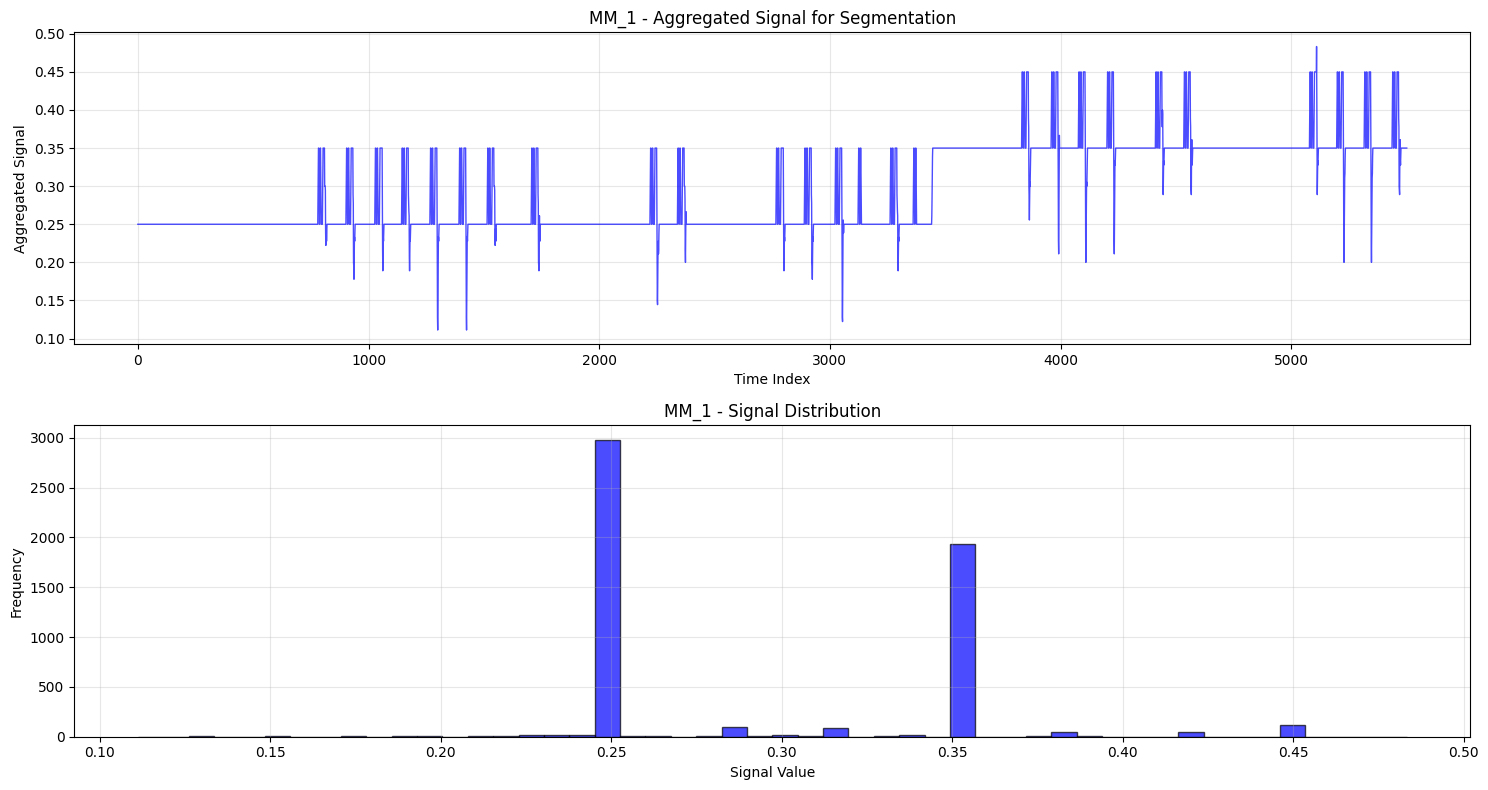


Signal Statistics for MM_1:
  Length: 5502
  Mean: 0.2941
  Std: 0.0554
  Min: 0.1111
  Max: 0.4833


In [5]:
# Let's test Task 2 on one station
print("=" * 60)
print("TASK 2: FEATURE ENGINEERING & STANDARDIZATION")
print("=" * 60)

engineer = FeatureEngineer()
station_signals = {}
station_dfs = {}

# Process the first station as an example
first_station = list(loader.station_data.keys())[0]
print(f"\nProcessing {first_station} as an example...")

station_df = loader.station_data[first_station].copy()
try:
    processed_df, aggregated_signal = engineer.engineer_features(station_df, first_station)
    station_signals[first_station] = aggregated_signal
    station_dfs[first_station] = processed_df
    print(f" Successfully engineered features for {first_station}")
    
    # Visualize the aggregated signal
    fig, ax = plt.subplots(2, 1, figsize=(15, 8))
    
    # Plot 1: Aggregated signal
    ax[0].plot(aggregated_signal.values, 'b-', alpha=0.7, linewidth=1)
    ax[0].set_xlabel('Time Index')
    ax[0].set_ylabel('Aggregated Signal')
    ax[0].set_title(f'{first_station} - Aggregated Signal for Segmentation')
    ax[0].grid(True, alpha=0.3)
    
    # Plot 2: Histogram of signal values
    ax[1].hist(aggregated_signal.values, bins=50, alpha=0.7, color='blue', edgecolor='black')
    ax[1].set_xlabel('Signal Value')
    ax[1].set_ylabel('Frequency')
    ax[1].set_title(f'{first_station} - Signal Distribution')
    ax[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nSignal Statistics for {first_station}:")
    print(f"  Length: {len(aggregated_signal)}")
    print(f"  Mean: {aggregated_signal.mean():.4f}")
    print(f"  Std: {aggregated_signal.std():.4f}")
    print(f"  Min: {aggregated_signal.min():.4f}")
    print(f"  Max: {aggregated_signal.max():.4f}")
    
except Exception as e:
    print(f" Error processing {first_station}: {e}")
    import traceback
    traceback.print_exc()

In [6]:
# ============================================================================
# TASK 3: SEGMENTATION IMPLEMENTATION
# ============================================================================

class Segmenter:
    """ClaSP-based segmentation with baseline comparison."""
    
    def __init__(self):
        self.segments = {}
        self.baseline_segments = {}
    
    def _recursive_binary_segmentation(self, signal_array: np.ndarray, n_segments: int, 
                                      window_size: str = "suss") -> np.ndarray:
        """
        Recursively apply binary segmentation using ClaSPEnsemble to get multiple segments.
        This is a fallback method.
        """
        if ClaSPEnsemble is None:
            raise ImportError("ClaSPEnsemble not available")
        
        change_points = []
        segments_to_find = n_segments - 1
        
        # Recursively split segments
        segments_to_split = [(0, len(signal_array))]
        
        while len(change_points) < segments_to_find and len(segments_to_split) > 0:
            start, end = segments_to_split.pop(0)
            if end - start < 20:  # Too short to split
                continue
            
            segment = signal_array[start:end]
            try:
                ensemble = ClaSPEnsemble(window_size=window_size)
                ensemble.fit(segment)
                cp = ensemble.split(sparse=True)
                if cp is not None and 0 < cp < len(segment):
                    global_cp = start + cp
                    change_points.append(global_cp)
                    # Add new segments to split
                    segments_to_split.append((start, global_cp))
                    segments_to_split.append((global_cp, end))
            except:
                continue
        
        return np.array(sorted(change_points))
    
    def segment_clasp_ensemble(self, signal: pd.Series, n_segments: Optional[int] = None,
                               window_size: str = "suss") -> np.ndarray:
        """
        Apply ClaSP Ensemble segmentation.
        
        Args:
            signal: 1D time series
            n_segments: Number of segments (if None, auto-detect)
            window_size: Window size parameter ("suss" for default)
        
        Returns:
            Array of change point indices
        """
        if ClaSPEnsemble is None:
            raise ImportError("claspy library not available. Install with: pip install claspy==0.2.7")
        
        if len(signal) < 10:
            # Too short for segmentation, return single segment
            return np.array([0, len(signal)])
        
        # Check for constant signal
        if signal.nunique() <= 1:
            # Constant signal, return single segment
            return np.array([0, len(signal)])
        
        signal_array = signal.values.reshape(-1, 1)  # ClaSP expects 2D
        
        if n_segments is None:
            # Auto-detect number of segments using binary segmentation
            try:
                # Use BinaryClaSPSegmentation with n_segments='learn' for auto-detection
                binary_seg = BinaryClaSPSegmentation(n_segments='learn', window_size=window_size)
                # Use fit_predict (standard method)
                change_points = binary_seg.fit_predict(signal_array)
                
                if isinstance(change_points, (int, np.integer)):
                    change_points = [change_points]
                change_points = np.array(change_points).flatten()
                n_segments = len(change_points) + 1
                print(f"     Auto-detected {n_segments} segments")
            except Exception as e:
                # Fallback: use heuristic
                n_segments = max(2, min(10, len(signal) // 100))
                print(f"     Using heuristic: {n_segments} segments (auto-detect failed: {e})")
        
        # Apply ClaSP segmentation
        # Use BinaryClaSPSegmentation for multiple segments (it accepts n_segments)
        # ClaSPEnsemble is only for binary segmentation (2 segments)
        change_points = None
        try:
            # Use BinaryClaSPSegmentation which supports n_segments parameter
            binary_seg = BinaryClaSPSegmentation(n_segments=n_segments, window_size=window_size)
            
            # Try fit_predict (standard method)
            try:
                change_points = binary_seg.fit_predict(signal_array)
            except (TypeError, AttributeError):
                # Fallback: try fit then predict
                try:
                    binary_seg.fit(signal_array)
                    change_points = binary_seg.predict()
                except:
                    # Last resort: try with 1D signal
                    change_points = binary_seg.fit_predict(signal.values)
                    
        except Exception as e1:
            # If BinaryClaSPSegmentation fails, try recursive binary segmentation with ClaSPEnsemble
            try:
                print(f"    ️ BinaryClaSPSegmentation failed, using recursive binary segmentation")
                change_points = self._recursive_binary_segmentation(signal_array, n_segments, window_size)
            except Exception as e2:
                raise RuntimeError(f"ClaSP segmentation failed: {e1}, {e2}")
        
        # Ensure change_points is a list/array
        if change_points is None:
            raise ValueError("Failed to get change points from ClaSP")
        
        if isinstance(change_points, (int, np.integer)):
            change_points = [change_points]
        change_points = np.array(change_points).flatten()
        
        # Remove any invalid indices
        change_points = change_points[(change_points > 0) & (change_points < len(signal))]
        change_points = np.unique(change_points)  # Remove duplicates
        
        # Convert to indices (ClaSP returns change points, we need segment boundaries)
        boundaries = [0] + sorted(change_points.tolist()) + [len(signal)]
        boundaries = np.unique(boundaries)  # Ensure unique boundaries
        
        return np.array(boundaries)
    
    def segment_baseline_pelt(self, signal: pd.Series, n_segments: Optional[int] = None) -> np.ndarray:
        """
        Baseline segmentation using PELT (ruptures library).
        
        Args:
            signal: 1D time series
            n_segments: Number of segments (if None, auto-detect)
        
        Returns:
            Array of segment boundary indices
        """
        if rpt is None:
            raise ImportError("ruptures library not available. Install with: pip install ruptures")
        
        signal_array = signal.values.reshape(-1, 1)
        
        # Use PELT algorithm (faster than Dynp for many segments)
        if n_segments is None:
            # Auto-detect using penalty (PELT is fast)
            algo = rpt.Pelt(model="rbf", min_size=2).fit(signal_array)
            change_points = algo.predict(pen=10)
        else:
            # For fixed number of segments, use Dynp but limit to reasonable number
            if n_segments > 20:
                # Too many segments, use PELT instead
                algo = rpt.Pelt(model="rbf", min_size=2).fit(signal_array)
                change_points = algo.predict(pen=10)
            else:
                # Use Dynp for small number of segments
                algo = rpt.Dynp(model="rbf", min_size=2, jump=5).fit(signal_array)  # jump=5 for speed
                change_points = algo.predict(n_bkps=n_segments - 1)
        
        boundaries = [0] + sorted(change_points) + [len(signal)]
        
        return np.array(boundaries)
    
    def evaluate_boundaries(self, boundaries: np.ndarray, state_changes: np.ndarray,
                           tolerance: int = 5) -> Dict:
        """
        Evaluate segmentation boundaries against state changes.
        
        Args:
            boundaries: Segment boundary indices
            state_changes: Indices where current_state changes
            tolerance: Tolerance window for matching (in samples)
        
        Returns:
            Dictionary with precision, recall, F1, and other metrics
        """
        if len(state_changes) == 0:
            pred_count = len(boundaries) - 2 if len(boundaries) > 2 else 0
            return {
                'precision': 0.0,
                'recall': 0.0,
                'f1': 0.0,
                'true_positives': 0,
                'false_positives': pred_count,
                'false_negatives': 0,
                'n_predicted': pred_count,
                'n_true': 0
            }
        
        # Remove first boundary (always 0) and last (always end)
        pred_boundaries = set(boundaries[1:-1])
        true_boundaries = set(state_changes)
        
        # Match boundaries within tolerance
        true_positives = 0
        matched_pred = set()
        matched_true = set()
        
        for pred_bp in pred_boundaries:
            for true_bp in true_boundaries:
                if abs(pred_bp - true_bp) <= tolerance and pred_bp not in matched_pred and true_bp not in matched_true:
                    true_positives += 1
                    matched_pred.add(pred_bp)
                    matched_true.add(true_bp)
                    break
        
        false_positives = len(pred_boundaries) - len(matched_pred)
        false_negatives = len(true_boundaries) - len(matched_true)
        
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0.0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0.0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
        
        return {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'true_positives': true_positives,
            'false_positives': false_positives,
            'false_negatives': false_negatives,
            'n_predicted': len(pred_boundaries),
            'n_true': len(true_boundaries)
        }
    def prune_boundaries(self, boundaries: np.ndarray, min_gap: int = 10):

        inner = sorted(boundaries[1:-1])
        pruned = []
        for b in inner:
          if not pruned or b - pruned[-1] > min_gap:
              pruned.append(b)
        return np.array([0] + pruned + [boundaries[-1]])
    def compute_true_boundaries(self, signal, min_jump=0.08):

      if not isinstance(signal, pd.Series):
          raise ValueError("Signal must be numeric pandas Series")

      sig = signal.values.astype(float)

      boundaries = []

      for i in range(1, len(sig)):
          jump = abs(sig[i] - sig[i-1])

          if jump > min_jump:
              boundaries.append(i)

      return np.array(boundaries)

    def compute_regime_aligned_gt(self, df, signal,smooth_window=25,jump_threshold=0.05,min_regime_len=100):
      """
      Ground truth aligned with signal regime structure.
      """

      # --- Smooth signal (remove micro noise) ---
      sig = pd.Series(signal).astype(float)
      smooth = sig.rolling(smooth_window, center=True).mean()
      smooth = smooth.fillna(method="bfill").fillna(method="ffill")

      # --- Detect major regime jumps ---
      diff = smooth.diff().abs().fillna(0)

      candidates = np.where(diff > jump_threshold)[0]

      # --- Enforce minimum regime duration ---
      boundaries = []
      last = 0

      for c in candidates:
          if c - last > min_regime_len:
              boundaries.append(c)
              last = c

      return np.array(boundaries)
    def validate_segment_statistics(self,signal, boundaries):

      sig = signal.values.astype(float)
      segments = []

      for i in range(len(boundaries) - 1):
          start = boundaries[i]
          end = boundaries[i+1]
          segments.append(sig[start:end])

      stats = []

      for i, seg in enumerate(segments):
          stats.append({
              "segment": i,
              "mean": np.mean(seg),
              "std": np.std(seg),
              "var": np.var(seg)
          })

      return pd.DataFrame(stats)
    def segment_separation_score(self, signal, boundaries):
      sig = signal.astype(float).values

      segments = [
          sig[boundaries[i]:boundaries[i+1]]
          for i in range(len(boundaries)-1)
      ]

      scores = []

      for i in range(len(segments)-1):
          m1, m2 = np.mean(segments[i]), np.mean(segments[i+1])
          v1, v2 = np.var(segments[i]), np.var(segments[i+1])

          separation = abs(m2 - m1) / np.sqrt(v1 + v2 + 1e-8)
          scores.append(separation)

      return np.mean(scores)

    def segment_stability_score(self, signal, boundaries):
      sig = signal.astype(float).values

      variances = []

      for i in range(len(boundaries)-1):
          seg = sig[boundaries[i]:boundaries[i+1]]
          variances.append(np.var(seg))

      return np.mean(variances)
    def boundary_strength_score(self, signal, boundaries):
      sig = signal.astype(float).values

      strengths = []

      for b in boundaries[1:-1]:
          jump = abs(sig[b] - sig[b-1])
          strengths.append(jump)

      return np.mean(strengths)

    def segmentation_explained_variance(self, signal, boundaries):
      sig = signal.astype(float).values

      total_var = np.var(sig)

      seg_vars = []

      for i in range(len(boundaries)-1):
          seg = sig[boundaries[i]:boundaries[i+1]]
          seg_vars.append(np.var(seg))

      within_var = np.mean(seg_vars)

      return 1 - (within_var / (total_var + 1e-8))
    def get_segment_time_ranges(self, df, boundaries):
      """
      Convert ClaSP boundaries into timestamp intervals.
      """

      timestamps = pd.to_datetime(df["timestamp"])

      segments = []

      for i in range(len(boundaries) - 1):
          start_idx = boundaries[i]
          end_idx = boundaries[i + 1] - 1

          segments.append({
              "segment": i,
              "start_index": start_idx,
              "end_index": end_idx,
              "start_time": timestamps.iloc[start_idx],
              "end_time": timestamps.iloc[end_idx]
          })

      return pd.DataFrame(segments)
    def enhance_signal_for_segmentation(self, signal,smooth_window=15,diff_weight=2.0):
      """
      Enhance regime structure before ClaSP.
      """

      sig = pd.Series(signal).astype(float)

      # Smooth noise
      smooth = sig.rolling(smooth_window, center=True).mean()
      smooth = smooth.fillna(method="bfill").fillna(method="ffill")

      # First derivative (change intensity)
      diff = smooth.diff().fillna(0)

      # Combine signal + change emphasis
      enhanced = smooth + diff_weight * diff

      return enhanced
    def segment_station(self, df: pd.DataFrame, signal: pd.Series, station: str,
                       use_baseline: bool = False) -> Dict:
        """
        Segment a station's time series.
        
        Returns:
            Dictionary with segments and evaluation metrics
        """
        print(f"\n   Segmenting {station}...")
        print(f"     Signal length: {len(signal)}")
        
        # Detect state changes for evaluation
        '''if 'current_state' in df.columns:
            state_changes = []
            prev_state = None
            for idx, state in enumerate(df['current_state']):
                if prev_state is not None and state != prev_state:
                    state_changes.append(idx)
                prev_state = state
            state_changes = np.array(state_changes)
            print(f"     State changes detected: {len(state_changes)}")
        else:
            state_changes = np.array([])'''
        state_changes = self.compute_regime_aligned_gt(df, signal)
        #state_changes = self.compute_true_boundaries(signal)
        print(f"     Signal-aligned GT boundaries: {len(state_changes)}")
        # Estimate number of segments based on state changes
        n_segments = max(2, len(state_changes) + 1) if len(state_changes) > 0 else None
        
        # ClaSP segmentation
        try:
            enhanced_signal = self.enhance_signal_for_segmentation(signal)
            boundaries = self.segment_clasp_ensemble(enhanced_signal, n_segments=None)

            boundaries = self.prune_boundaries(boundaries, min_gap=3)
            print(f"     ClaSP boundaries: {len(boundaries) - 1} segments")

            stats = self.validate_segment_statistics(signal, boundaries)
            print("\n Segment statistics:")
            print(stats)
            segment_times = self.get_segment_time_ranges(df, boundaries)
            print("\n Segment time ranges:")
            print(segment_times)
        except Exception as e:
            print(f"     ClaSP failed: {e}")
            # Fallback: simple equal-length segments
            n_segments = max(2, min(10, len(signal) // 100))
            boundaries = np.linspace(0, len(signal), n_segments + 1, dtype=int)
            print(f"    ️ Using fallback segmentation: {n_segments} segments")

        # Baseline segmentation (if requested) - skip if too many segments (too slow)
        baseline_boundaries = None
        if use_baseline and rpt is not None:
            # Skip baseline if n_segments is too large (Dynp is very slow)
            if n_segments is not None and n_segments > 20:
                print(f"    ️ Skipping baseline segmentation (too many segments: {n_segments}, would be too slow)")
            else:
                try:
                    print(f"     Running baseline segmentation (PELT)...")
                    baseline_boundaries = self.segment_baseline_pelt(signal, n_segments=n_segments)
                    print(f"     Baseline (PELT) boundaries: {len(baseline_boundaries) - 1} segments")
                except Exception as e:
                    print(f"     Baseline segmentation failed: {e}")
        
        # Evaluate boundaries
        print(f"     Evaluating boundaries...")
        try:
            '''metrics = self.evaluate_boundaries_timestamp(
                boundaries,
                state_changes,
                df["timestamp"],
                tolerance_seconds=5.0
            )'''

            metrics = {
                  "separation_score": self.segment_separation_score(signal, boundaries),
                  "stability_score": self.segment_stability_score(signal, boundaries),
                  "boundary_strength": self.boundary_strength_score(signal, boundaries),
                  "explained_variance": self.segmentation_explained_variance(signal, boundaries)
            }
            #metrics = self.evaluate_boundaries(boundaries, state_changes,tolerance=20)
            #print(f"     Evaluation complete: P={metrics['precision']:.3f}, R={metrics['recall']:.3f}, F1={metrics['f1']:.3f}")
            print("\nSegmentation credibility metrics:")
            for k, v in metrics.items():
                print(f"{k}: {v:.3f}")

            #print('Specially focussed metrics section',metrics)
        except Exception as e:
            print(f"     Error in evaluation: {e}")
            # Use default metrics on error
            metrics = {
                'precision': 0.0,
                'recall': 0.0,
                'f1': 0.0,
                'true_positives': 0,
                'false_positives': 0,
                'false_negatives': 0,
                'n_predicted': len(boundaries) - 2,
                'n_true': len(state_changes)
            }

            metrics = {
                "separation_score": 0,
                "stability_score": 0,
                "boundary_strength": 0,
                "explained_variance":0
            }

        result = {
            'station': station,
            'boundaries': boundaries,
            'baseline_boundaries': baseline_boundaries,
            'state_changes': state_changes,
            'metrics': metrics,
            'n_segments': len(boundaries) - 1
        }
        print(f"     Segmentation complete for {station}")
        return result

Information about metrics used for defining information

Separation

Are regimes truly different?

Measures how far apart the segments are statistically.

    High separation means each segment represents a distinct machine behavior.
    Low separation means segments look similar and may not represent real operating modes.

Interpretation:

“Do segments describe different behaviors or just minor fluctuations?”

Stability

Are regimes internally consistent?

Measures how stable the signal is inside each segment.

    High stability → behavior is steady within a regime
    Low stability → segment still contains noise or mixed behavior

Interpretation:

“Does each segment represent a clean, stable operating phase?”

Boundary strength

Are transitions sharp?

Measures how strong the signal change is at segment boundaries.

    High boundary strength → clear transition or event
    Low boundary strength → gradual shift between regimes

Interpretation:

“Does the machine clearly switch behavior, or drift slowly?”

Explained variance

Does segmentation capture real structure?

Measures how much of the signal’s variability is explained by segmentation.

    High value → segmentation matches true signal structure
    Near zero → segmentation adds little insight
    Negative → segmentation is meaningless

Interpretation:

“Does segmentation actually model the machine’s behavior?”

TASK 3: SEGMENTATION IMPLEMENTATION

Testing segmentation on MM_1...

   Segmenting MM_1...
     Signal length: 5502
     Signal-aligned GT boundaries: 0
     Auto-detected 3 segments
     ClaSP boundaries: 3 segments

 Segment statistics:
   segment      mean       std       var
0        0  0.256526  0.026095  0.000681
1        1  0.259222  0.027029  0.000731
2        2  0.355639  0.030314  0.000919

 Segment time ranges:
   segment  start_index  end_index              start_time  \
0        0            0       3079 2023-01-30 13:06:20.230   
1        1         3080       3426 2023-02-06 14:59:09.480   
2        2         3427       5501 2023-02-06 15:10:46.480   

                 end_time  
0 2023-02-06 14:59:07.470  
1 2023-02-06 15:10:44.470  
2 2023-03-20 11:10:51.940  
     Evaluating boundaries...

Segmentation credibility metrics:
separation_score: 1.223
stability_score: 0.001
boundary_strength: 0.000
explained_variance: 0.747
     Segmentation complete for MM_1


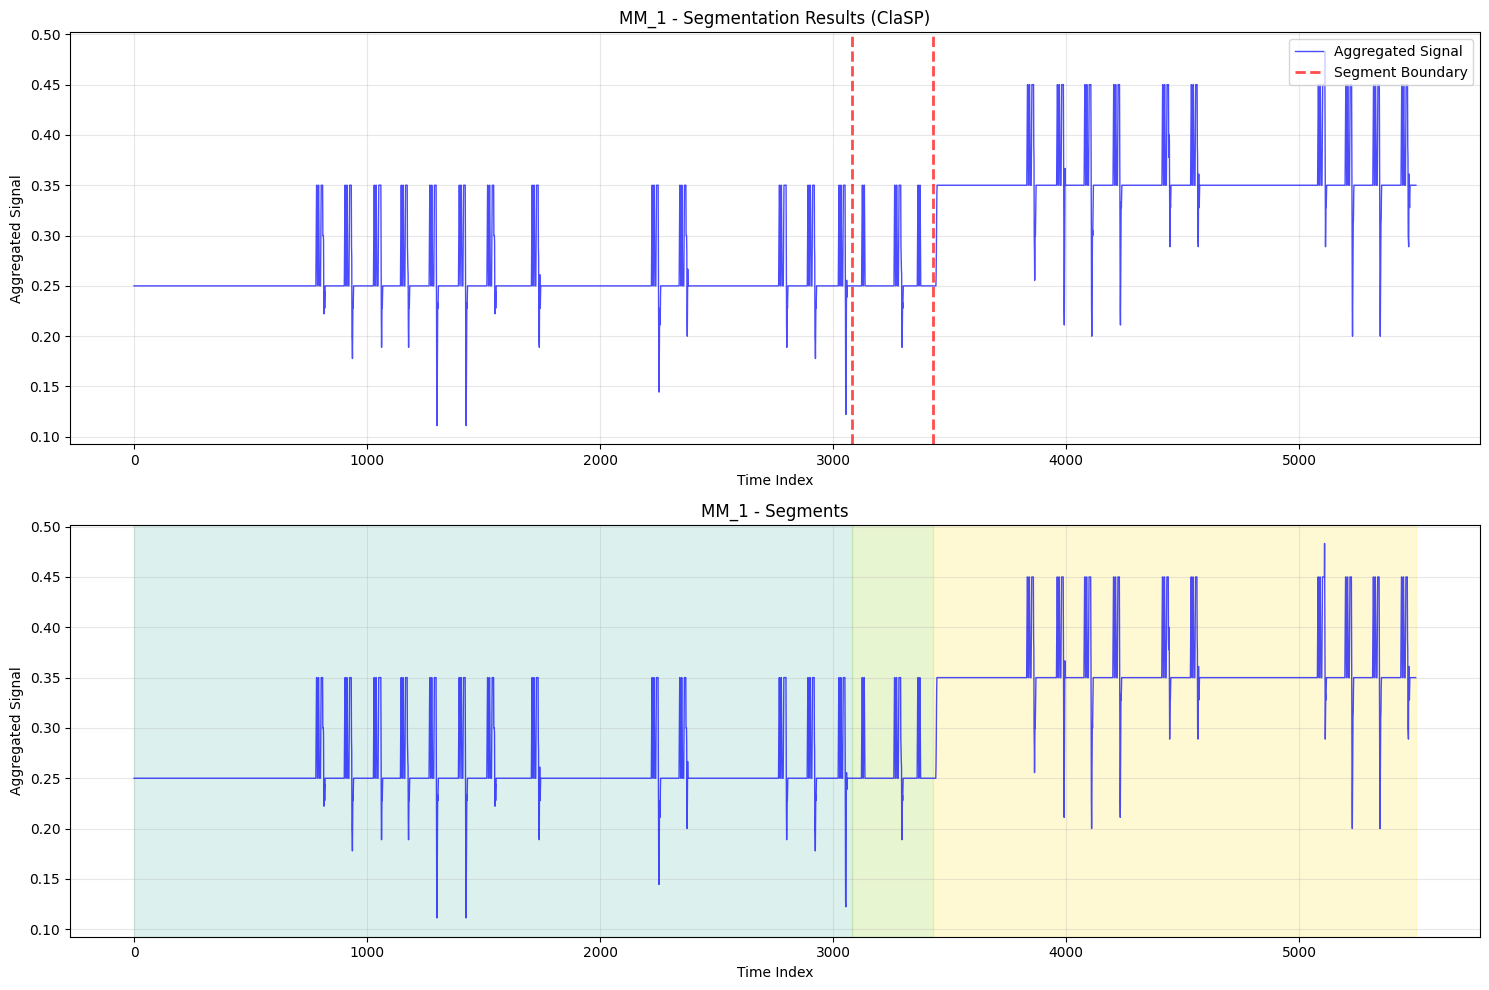


 Detailed Metrics for MM_1:
----------------------------------------
separation_score: 1.223
stability_score: 0.001
boundary_strength: 0.000
explained_variance: 0.747


In [7]:
# Let's test Task 3 on the example station
print("=" * 60)
print("TASK 3: SEGMENTATION IMPLEMENTATION")
print("=" * 60)

segmenter = Segmenter()

if first_station in station_signals:
    print(f"\nTesting segmentation on {first_station}...")
    result = segmenter.segment_station(
        station_dfs[first_station],
        station_signals[first_station],
        first_station,
        use_baseline=False
    )
    
    # Visualize the segmentation results inline
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))
    
    # Plot 1: Aggregated signal with boundaries
    signal = station_signals[first_station]
    boundaries = result['boundaries']
    state_changes = result['state_changes']
    
    axes[0].plot(signal.values, 'b-', alpha=0.7, linewidth=1, label='Aggregated Signal')
    
    # Draw segment boundaries
    if len(boundaries) > 2:
        for i, bp in enumerate(boundaries[1:-1]):
            axes[0].axvline(bp, color='r', linestyle='--', linewidth=2, alpha=0.7, 
                          label='Segment Boundary' if i == 0 else '')
    
    # Draw state changes
    if len(state_changes) > 0:
        for i, sc in enumerate(state_changes):
            axes[0].axvline(sc, color='g', linestyle=':', linewidth=1.5, alpha=0.5, 
                          label='State Change' if i == 0 else '')
    
    axes[0].set_xlabel('Time Index')
    axes[0].set_ylabel('Aggregated Signal')
    axes[0].set_title(f'{first_station} - Segmentation Results (ClaSP)')
    axes[0].legend(loc='upper right')
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Segment visualization
    colors = plt.cm.Set3(np.linspace(0, 1, len(boundaries)-1))
    for i in range(len(boundaries)-1):
        start = boundaries[i]
        end = boundaries[i+1]
        axes[1].axvspan(start, end, alpha=0.3, color=colors[i % len(colors)])
    
    axes[1].plot(signal.values, 'b-', alpha=0.7, linewidth=1)
    axes[1].set_xlabel('Time Index')
    axes[1].set_ylabel('Aggregated Signal')
    axes[1].set_title(f'{first_station} - Segments')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Display metrics in a nice format
    metrics = result['metrics']
    print(f"\n Detailed Metrics for {first_station}:")
    print("-" * 40)
    #print(f"Precision:  {metrics['precision']:.3f}")
    #print(f"Recall:     {metrics['recall']:.3f}")
    #print(f"F1 Score:   {metrics['f1']:.3f}")
    #print(f"True Positives:  {metrics['true_positives']}")
    #print(f"False Positives: {metrics['false_positives']}")
    #print(f"False Negatives: {metrics['false_negatives']}")
    #print(f"Predicted Boundaries: {metrics['n_predicted']}")
    #print(f"True Boundaries:      {metrics['n_true']}")
    for k, v in metrics.items():
      print(f"{k}: {v:.3f}")
else:
    print(f" No signal found for {first_station}")

In [8]:
# ============================================================================
# TASK 4: PIPELINE INTEGRATION & EXPORT
# ============================================================================

class CBRExporter:
    """Export segments in CBR-ready format."""
    
    @staticmethod
    def create_segment_dict(df: pd.DataFrame, station: str, seg_id: int,
                           start_idx: int, end_idx: int,
                           aggregated_signal: pd.Series) -> Dict:
        """
        Create a single segment dictionary in CBR format.
        
        Args:
            df: Full DataFrame for the station
            station: Station name
            seg_id: Segment ID
            start_idx: Start index (inclusive)
            end_idx: End index (exclusive)
            aggregated_signal: Aggregated signal for feature extraction
        
        Returns:
            Segment dictionary
        """
        segment_df = df.iloc[start_idx:end_idx].copy()
        
        # Extract features (aggregated statistics)
        sensor_cols = [col for col in segment_df.columns if col not in 
                      ['id', 'station', 'timestamp', 'current_state', 'current_task',
                       'current_sub_task', 'source_file', 'hbw1_current_stock']]
        
        features = {}
        for col in sensor_cols:
            if segment_df[col].dtype in ['int64', 'float64', 'int32', 'float32']:
                mean_val = segment_df[col].mean()
                std_val = segment_df[col].std() if len(segment_df) > 1 else 0.0
                # Handle NaN values
                if pd.notna(mean_val):
                    features[f"mean_{col}"] = float(mean_val)
                if pd.notna(std_val):
                    features[f"std_{col}"] = float(std_val)
        
        # Dominant state
        if 'current_state' in segment_df.columns and len(segment_df) > 0:
            mode_result = segment_df['current_state'].mode()
            dominant_state = mode_result.iloc[0] if len(mode_result) > 0 else "unknown"
            state_changes = max(0, int((segment_df['current_state'] != segment_df['current_state'].shift()).sum() - 1))
        else:
            dominant_state = "unknown"
            state_changes = 0
        
        # Timestamps
        if 'timestamp' in segment_df.columns and len(segment_df) > 0:
            start_time = segment_df['timestamp'].iloc[0]
            end_time = segment_df['timestamp'].iloc[-1]
        else:
            start_time = None
            end_time = None
        
        segment_dict = {
            "station": station,
            "segment_id": seg_id,
            "start_index": int(start_idx),
            "end_index": int(end_idx),
            "start_time": str(start_time) if start_time else None,
            "end_time": str(end_time) if end_time else None,
            "features": features,
            "dominant_state": str(dominant_state),
            "state_changes": int(max(0, state_changes)),
            "length": int(end_idx - start_idx)
        }
        
        return segment_dict
    
    @staticmethod
    def export_segments(segmentation_result: Dict, df: pd.DataFrame,
                       aggregated_signal: pd.Series, output_file: str = None) -> List[Dict]:
        """
        Export all segments for a station.
        
        Returns:
            List of segment dictionaries
        """
        station = segmentation_result['station']
        boundaries = segmentation_result['boundaries']
        
        segments = []
        for seg_id in range(len(boundaries) - 1):
            start_idx = boundaries[seg_id]
            end_idx = boundaries[seg_id + 1]
            
            segment_dict = CBRExporter.create_segment_dict(
                df, station, seg_id + 1, start_idx, end_idx, aggregated_signal
            )
            segments.append(segment_dict)
        
        # Save to file if requested
        if output_file:
            with open(output_file, 'w') as f:
                json.dump(segments, f, indent=2, default=str)
            print(f"   Exported {len(segments)} segments to {output_file}")
        
        return segments

In [9]:
# ============================================================================
# VISUALIZATION FUNCTION (INLINE DISPLAY)
# ============================================================================

def visualize_segments_inline(df: pd.DataFrame, signal: pd.Series, segmentation_result: Dict,
                             station: str, show_plot: bool = True):
    """
    Visualize segmentation results with state changes overlaid - inline display.
    """
    if len(signal) == 0:
        print(f"  ️ Warning: Empty signal for {station}, skipping visualization")
        return
    
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    
    boundaries = segmentation_result['boundaries']
    state_changes = segmentation_result['state_changes']
    
    # Plot 1: Aggregated signal with boundaries
    ax1 = axes[0]
    timestamps = df['timestamp'].values if 'timestamp' in df.columns else np.arange(len(signal))
    
    ax1.plot(timestamps, signal.values, 'b-', alpha=0.7, label='Aggregated Signal', linewidth=1)
    
    # Draw segment boundaries
    if len(boundaries) > 2:
        for i, bp in enumerate(boundaries[1:-1]):
            if bp < len(timestamps):
                ax1.axvline(timestamps[bp], color='r', linestyle='--', linewidth=2, alpha=0.7, 
                           label='Segment Boundary' if i == 0 else '')
    
    # Draw state changes
    if len(state_changes) > 0:
        for i, sc in enumerate(state_changes):
            if sc < len(timestamps):
                ax1.axvline(timestamps[sc], color='g', linestyle=':', linewidth=1.5, alpha=0.5, 
                           label='State Change' if i == 0 else '')
    
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Aggregated Signal')
    ax1.set_title(f'{station} - Segmentation Results (ClaSP)')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    
    # Format x-axis for timestamps
    if 'timestamp' in df.columns:
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
        plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
    
    # Plot 2: Segments with different colors
    ax2 = axes[1]
    colors = plt.cm.Set3(np.linspace(0, 1, len(boundaries)-1))
    for i in range(len(boundaries)-1):
        start = boundaries[i]
        end = boundaries[i+1]
        if start < len(timestamps) and end <= len(timestamps):
            ax2.axvspan(timestamps[start], timestamps[end-1] if end < len(timestamps) else timestamps[-1], 
                       alpha=0.3, color=colors[i % len(colors)], label=f'Segment {i+1}' if i < 5 else '')
    
    ax2.plot(timestamps, signal.values, 'b-', alpha=0.7, linewidth=1)
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Aggregated Signal')
    ax2.set_title(f'{station} - Segments (colored by segment)')
    if len(boundaries) - 1 <= 5:
        ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)
    
    if 'timestamp' in df.columns:
        ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
        plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
    
    # Plot 3: Current state over time
    ax3 = axes[2]
    if 'current_state' in df.columns:
        # Encode states as numbers for plotting
        states = df['current_state'].values
        unique_states = pd.Series(states).unique()
        state_map = {state: idx for idx, state in enumerate(unique_states)}
        state_encoded = [state_map[s] for s in states]
        
        ax3.plot(timestamps, state_encoded, 'o-', markersize=3, alpha=0.6, label='Current State')
        ax3.set_yticks(range(len(unique_states)))
        ax3.set_yticklabels(unique_states)
        ax3.set_xlabel('Time')
        ax3.set_ylabel('State')
        ax3.set_title(f'{station} - State Transitions')
        ax3.legend(loc='upper right')
        ax3.grid(True, alpha=0.3)
        
        if 'timestamp' in df.columns:
            ax3.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
            plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)
    
    plt.tight_layout()
    
    if show_plot:
        plt.show()
    
    return fig

In [10]:
# ============================================================================
# COMPLETE PIPELINE WITH INLINE VISUALIZATION
# ============================================================================

def run_complete_pipeline(data_dir: str = "data/data-radiant-eval-paper/factory/evaluation/iot_logs", 
                         output_dir: str = "segmentation_output",
                         stations_to_process: List[str] = None,
                         visualize_inline: bool = True):
    """
    Run complete segmentation pipeline with inline visualization.
    
    Args:
        data_dir: Directory containing JSONL files
        output_dir: Directory for output files
        stations_to_process: List of stations to process (None = all)
        visualize_inline: Whether to show visualizations inline
    """
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    # TASK 1: Data Loading
    print("=" * 60)
    print("TASK 1: DATA LOADING & EXPLORATION")
    print("=" * 60)
    
    loader = IoTDataLoader(data_dir)
    df = loader.process_all()
    
    # TASK 2: Feature Engineering
    print("\n" + "=" * 60)
    print("TASK 2: FEATURE ENGINEERING & STANDARDIZATION")
    print("=" * 60)
    
    engineer = FeatureEngineer()
    station_signals = {}
    station_dfs = {}
    
    stations = stations_to_process if stations_to_process else list(loader.station_data.keys())
    
    for station in stations:
        print(f"\n Processing {station}...")
        station_df = loader.station_data[station].copy()
        
        try:
            processed_df, aggregated_signal = engineer.engineer_features(station_df, station)
            station_signals[station] = aggregated_signal
            station_dfs[station] = processed_df
            print(f"   Successfully engineered features for {station}")
        except Exception as e:
            print(f"   Error processing {station}: {e}")
            continue
    
    # TASK 3: Segmentation
    print("\n" + "=" * 60)
    print("TASK 3: SEGMENTATION IMPLEMENTATION")
    print("=" * 60)
    
    segmenter = Segmenter()
    segmentation_results = {}
    station_visualizations = {}
    
    for station in stations:
        if station not in station_signals:
            continue
        
        try:
            print(f"\n Segmenting {station}...")
            result = segmenter.segment_station(
                station_dfs[station],
                station_signals[station],
                station,
                use_baseline=False
            )
            segmentation_results[station] = result
            
            # Print metrics
            metrics = result['metrics']
            '''print(f"\n Evaluation metrics for {station}:")
            print(f"    Precision: {metrics['precision']:.3f}")
            print(f"    Recall: {metrics['recall']:.3f}")
            print(f"    F1 Score: {metrics['f1']:.3f}")
            print(f"    TP: {metrics['true_positives']}, FP: {metrics['false_positives']}, FN: {metrics['false_negatives']}")
            print(f"    Predicted boundaries: {metrics.get('n_predicted', 'N/A')}, True boundaries: {metrics.get('n_true', 'N/A')}")'''
            for k, v in metrics.items():
              print(f"{k}: {v:.3f}")

            # Create inline visualization
            if visualize_inline:
                print(f"\n Generating inline visualization for {station}...")
                fig = visualize_segments_inline(
                    station_dfs[station],
                    station_signals[station],
                    result,
                    station,
                    show_plot=True
                )
                station_visualizations[station] = fig
            
        except Exception as e:
            print(f"   Error segmenting {station}: {e}")
            continue
    
    # TASK 4: Export
    print("\n" + "=" * 60)
    print("TASK 4: PIPELINE INTEGRATION & EXPORT")
    print("=" * 60)
    
    all_segments = {}
    for station in stations:
        if station in segmentation_results and station in station_signals:
            try:
                segments = CBRExporter.export_segments(
                    segmentation_results[station],
                    station_dfs[station],
                    station_signals[station],
                    output_file=str(output_path / f"{station}_segments.json")
                )
                all_segments[station] = segments
                print(f"   Exported {len(segments)} segments for {station}")
                
                # Show sample segment
                if len(segments) > 0:
                    print(f"   Sample segment for {station}:")
                    sample_segment = segments[0]
                    print(f"    Segment ID: {sample_segment['segment_id']}")
                    print(f"    Length: {sample_segment['length']} samples")
                    print(f"    Dominant State: {sample_segment['dominant_state']}")
                    print(f"    Features: {len(sample_segment['features'])} sensor statistics")
                
            except Exception as e:
                print(f"   Error exporting {station}: {e}")
    
    # Summary export
    summary = {
        'total_stations': len(all_segments),
        'stations': list(all_segments.keys()),
        'total_segments': sum(len(segs) for segs in all_segments.values()),
        'segments_per_station': {station: len(segs) for station, segs in all_segments.items()},
        'evaluation_metrics': {
            station: result['metrics'] 
            for station, result in segmentation_results.items()
        }
    }
    
    with open(output_path / "segmentation_summary.json", 'w') as f:
        json.dump(summary, f, indent=2, default=str)
    
    print(f"\n{'=' * 60}")
    print(" PIPELINE COMPLETE")
    print(f"{'=' * 60}")
    print(f" Processed {len(all_segments)} stations")
    print(f" Total segments: {summary['total_segments']}")
    print(f" Output directory: {output_path}")
    
    # Display final summary
    print(f"\n FINAL SUMMARY:")
    print("-" * 40)
    for station, segs in all_segments.items():
        metrics = summary['evaluation_metrics'].get(station, {})
        print(f"{station}: {len(segs)} segments | separation_score: {metrics.get('separation_score', 0):.3f} | "
              f"stability_score: {metrics.get('stability_score', 0):.3f} | boundary_strength: {metrics.get('boundary_strength', 0):.3f} | "
              f"explained_variance: {metrics.get('explained_variance', 0):.3f}")

    return {
        'loader': loader,
        'engineer': engineer,
        'segmenter': segmenter,
        'segmentation_results': segmentation_results,
        'all_segments': all_segments,
        'summary': summary,
        'visualizations': station_visualizations
    }

 Starting IoT Segmentation Pipeline...
TASK 1: DATA LOADING & EXPLORATION
TASK 1: DATA LOADING & EXPLORATION
 Loading 5 JSONL files...
   Loading 1.jsonl...
   Loading 2.jsonl...
   Loading 3.jsonl...
   Loading 4.jsonl...
   Loading 5.jsonl...
 Loaded 38479 total records

 Parsing timestamps...
 Handling mixed numeric types...
 Expanding nested structures...

 Splitting data by station...
   Station MM_1: 5502 records
   Station HBW_1: 5482 records
   Station EC_1: 5503 records
   Station SM_1: 5499 records
   Station VGR_1: 5492 records
   Station OV_1: 5500 records
   Station WT_1: 5501 records

 Generating diagnostics...

DIAGNOSTICS SUMMARY
 Total records: 38479

 Stations: ['EC_1', 'MM_1', 'WT_1', 'OV_1', 'SM_1', 'VGR_1', 'HBW_1']
  EC_1: 5503 records
  MM_1: 5502 records
  WT_1: 5501 records
  OV_1: 5500 records
  SM_1: 5499 records
  VGR_1: 5492 records
  HBW_1: 5482 records

 Time ranges:
  MM_1:
    Start: 2023-01-30 13:06:20.230000
    End: 2023-03-20 11:10:51.940000
    Dur

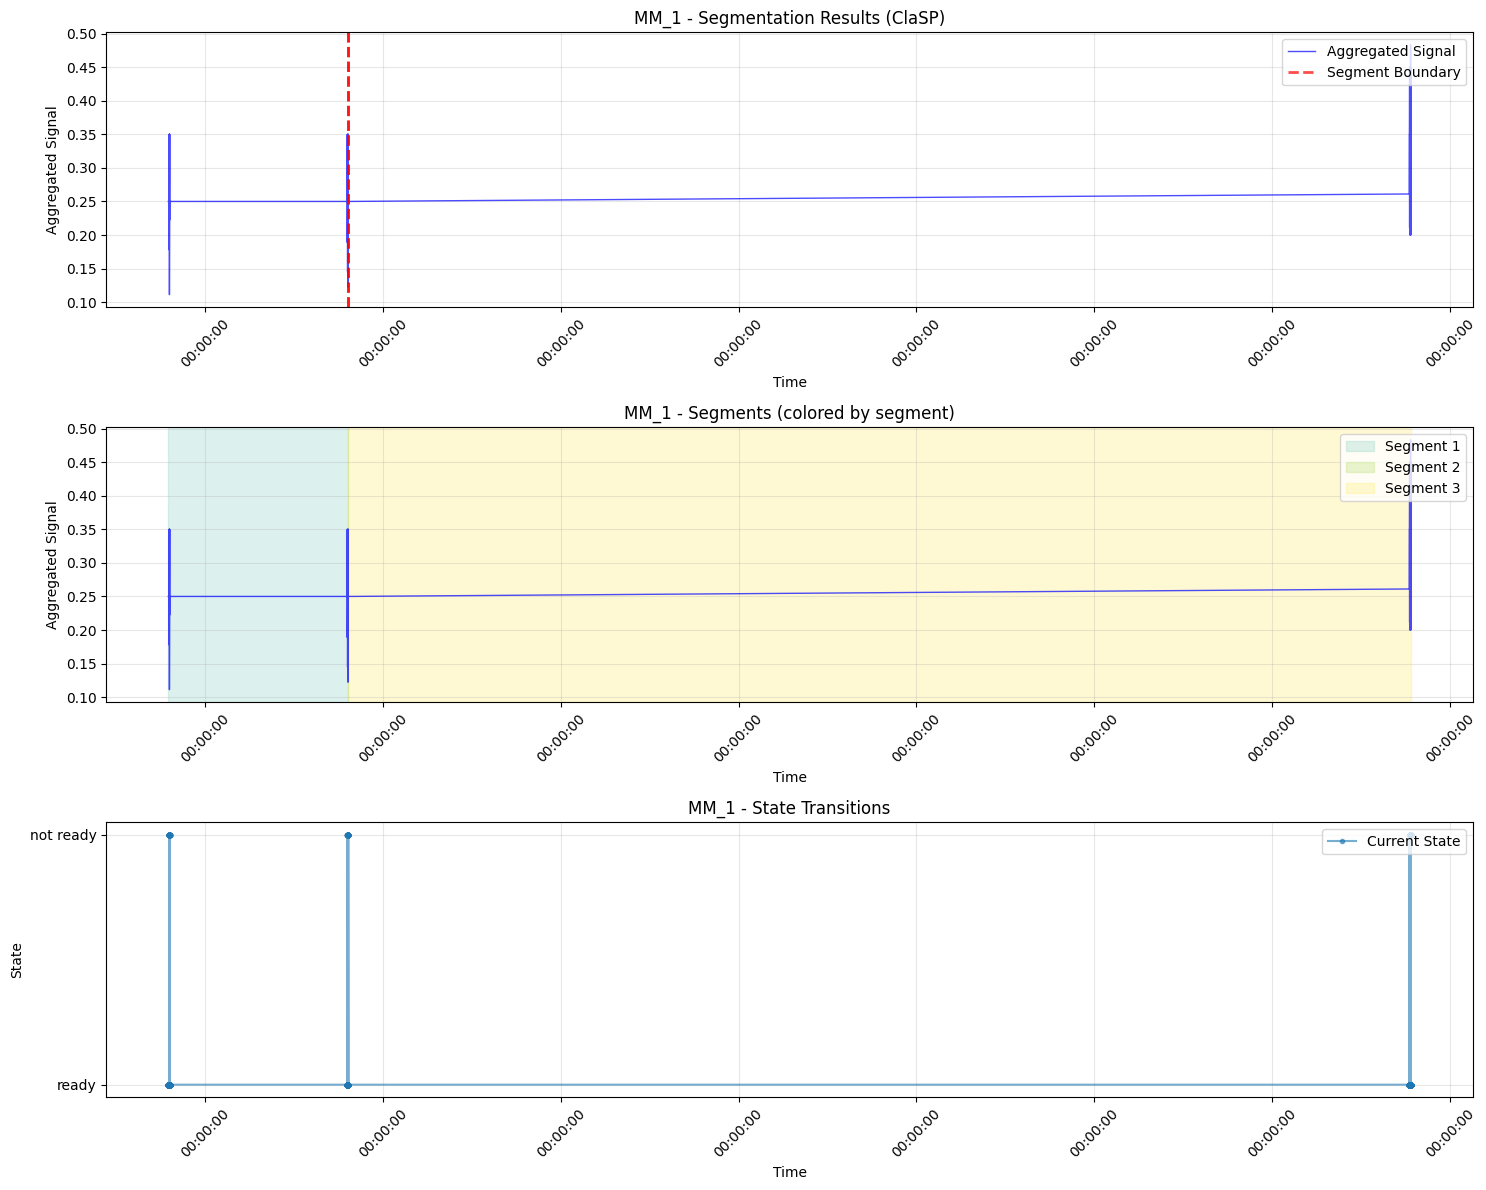


 Segmenting HBW_1...

   Segmenting HBW_1...
     Signal length: 5482
     Signal-aligned GT boundaries: 0
     Auto-detected 5 segments
     ClaSP boundaries: 5 segments

 Segment statistics:
   segment      mean       std       var
0        0  0.337803  0.046172  0.002132
1        1  0.329248  0.035943  0.001292
2        2  0.351069  0.051671  0.002670
3        3  0.328940  0.044399  0.001971
4        4  0.311571  0.051489  0.002651

 Segment time ranges:
   segment  start_index  end_index              start_time  \
0        0            0        751 2023-01-30 13:06:20.240   
1        1          752       1528 2023-01-30 13:53:36.040   
2        2         1529       3019 2023-01-30 14:19:44.970   
3        3         3020       3442 2023-02-06 14:57:36.210   
4        4         3443       5481 2023-03-20 09:46:05.710   

                 end_time  
0 2023-01-30 13:53:34.030  
1 2023-01-30 14:19:42.970  
2 2023-02-06 14:57:34.190  
3 2023-03-20 09:46:03.710  
4 2023-03-20 11:10:51.94

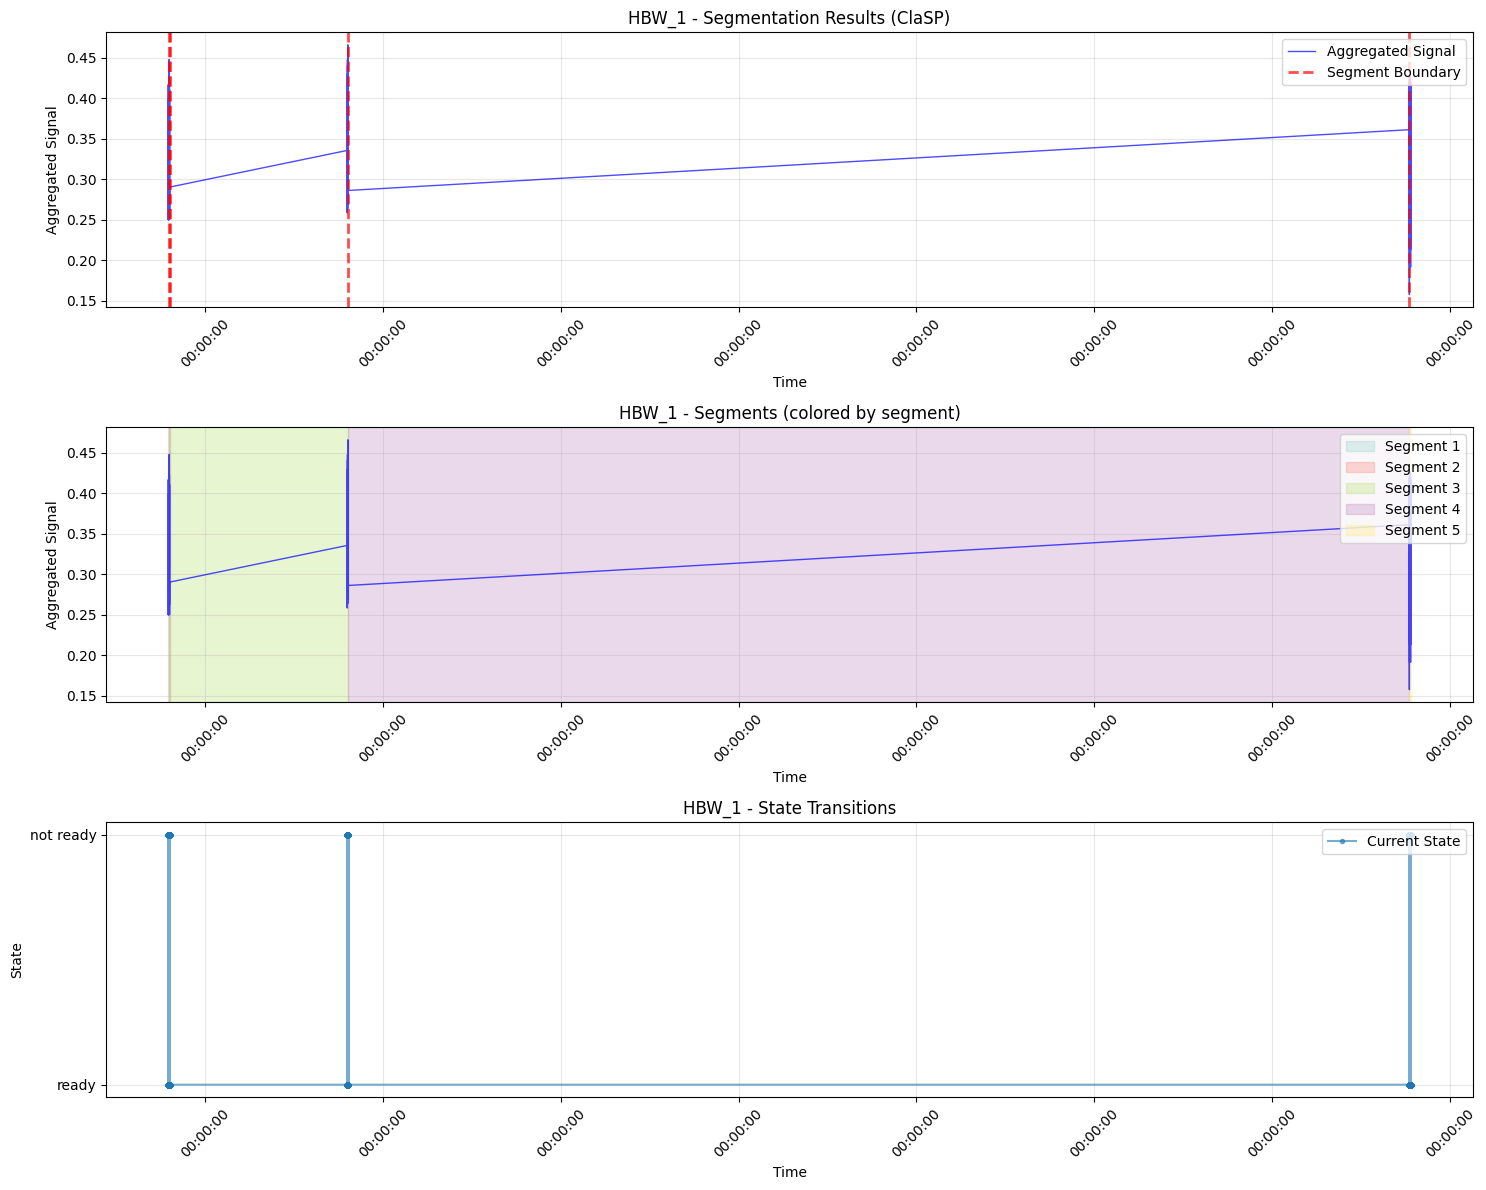


 Segmenting EC_1...

   Segmenting EC_1...
     Signal length: 5503
     Signal-aligned GT boundaries: 0
     Auto-detected 1 segments
     ClaSP boundaries: 1 segments

 Segment statistics:
   segment      mean       std       var
0        0  0.036859  0.035227  0.001241

 Segment time ranges:
   segment  start_index  end_index              start_time  \
0        0            0       5502 2023-01-30 13:06:20.270   

                 end_time  
0 2023-03-20 11:10:51.740  
     Evaluating boundaries...

Segmentation credibility metrics:
separation_score: nan
stability_score: 0.001
boundary_strength: nan
explained_variance: 0.000
     Segmentation complete for EC_1
separation_score: nan
stability_score: 0.001
boundary_strength: nan
explained_variance: 0.000

 Generating inline visualization for EC_1...


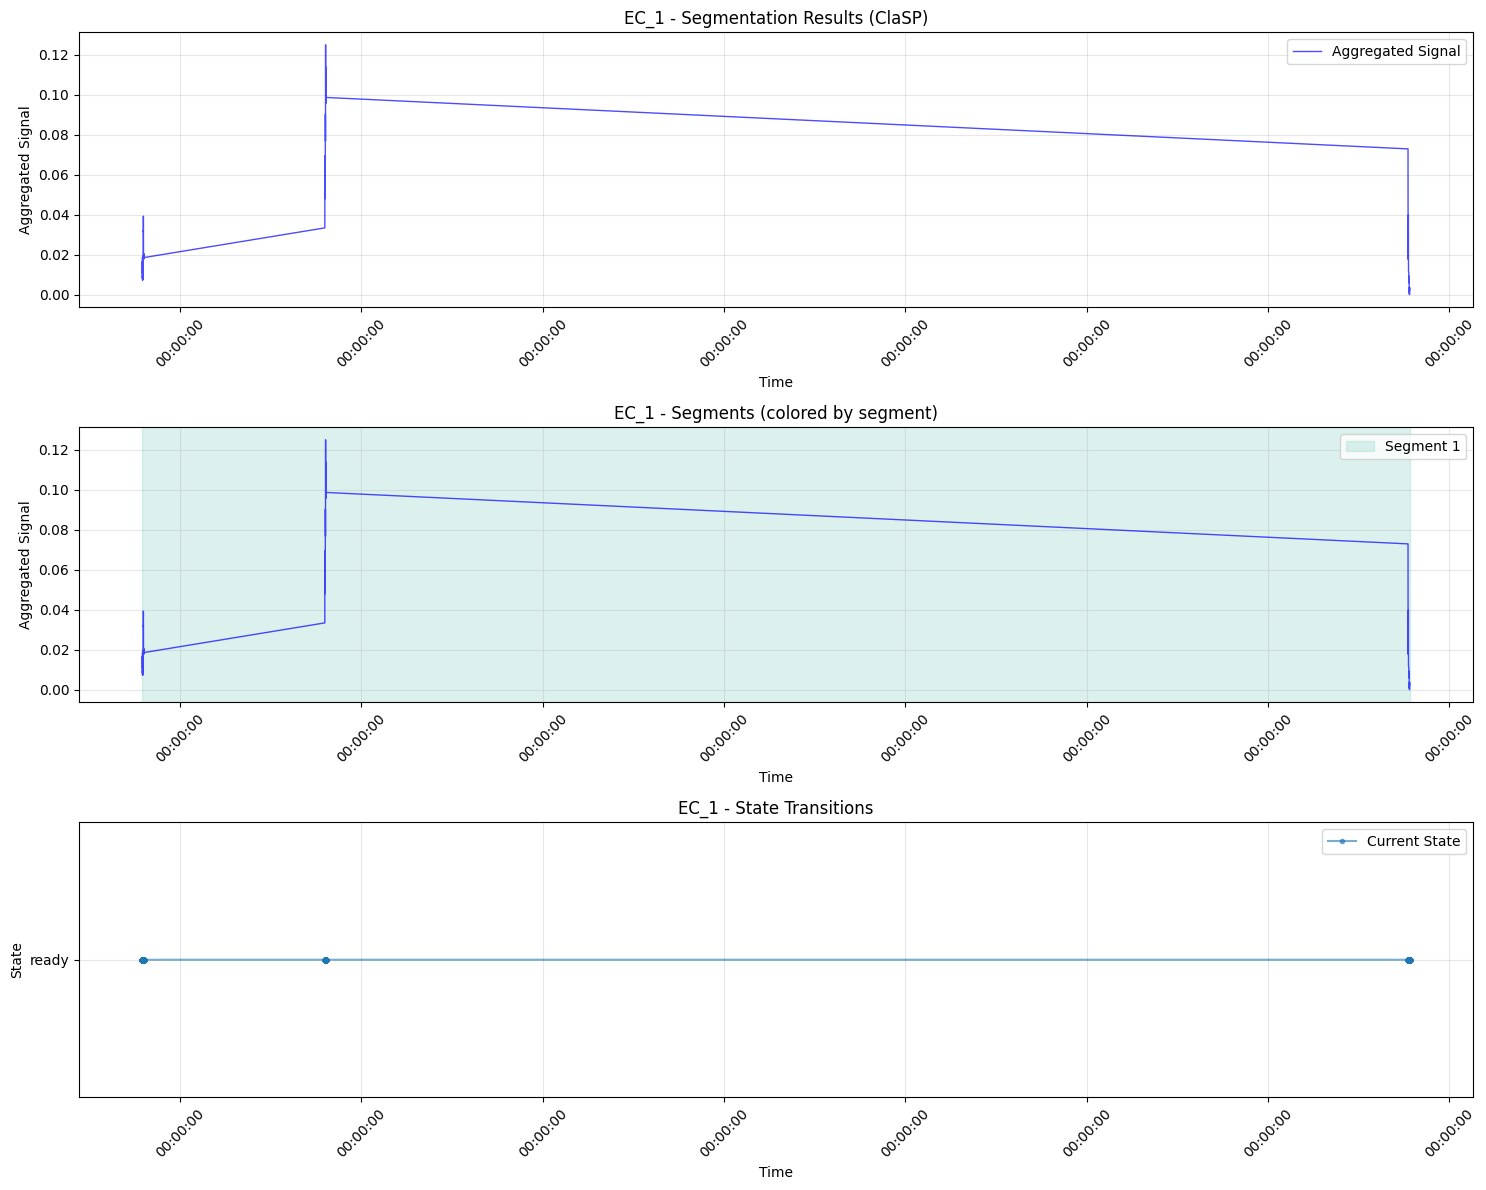


 Segmenting SM_1...

   Segmenting SM_1...
     Signal length: 5499
     Signal-aligned GT boundaries: 0
     Auto-detected 3 segments
     ClaSP boundaries: 3 segments

 Segment statistics:
   segment      mean       std       var
0        0  0.084547  0.014919  0.000223
1        1  0.207471  0.147081  0.021633
2        2  0.570148  0.025654  0.000658

 Segment time ranges:
   segment  start_index  end_index              start_time  \
0        0            0       1235 2023-01-30 13:06:20.270   
1        1         1236       3774 2023-01-30 14:09:37.960   
2        2         3775       5498 2023-03-20 09:56:47.870   

                 end_time  
0 2023-01-30 14:09:35.960  
1 2023-03-20 09:56:45.860  
2 2023-03-20 11:10:51.290  
     Evaluating boundaries...

Segmentation credibility metrics:
separation_score: 1.630
stability_score: 0.008
boundary_strength: 0.000
explained_variance: 0.842
     Segmentation complete for SM_1
separation_score: 1.630
stability_score: 0.008
boundary_stren

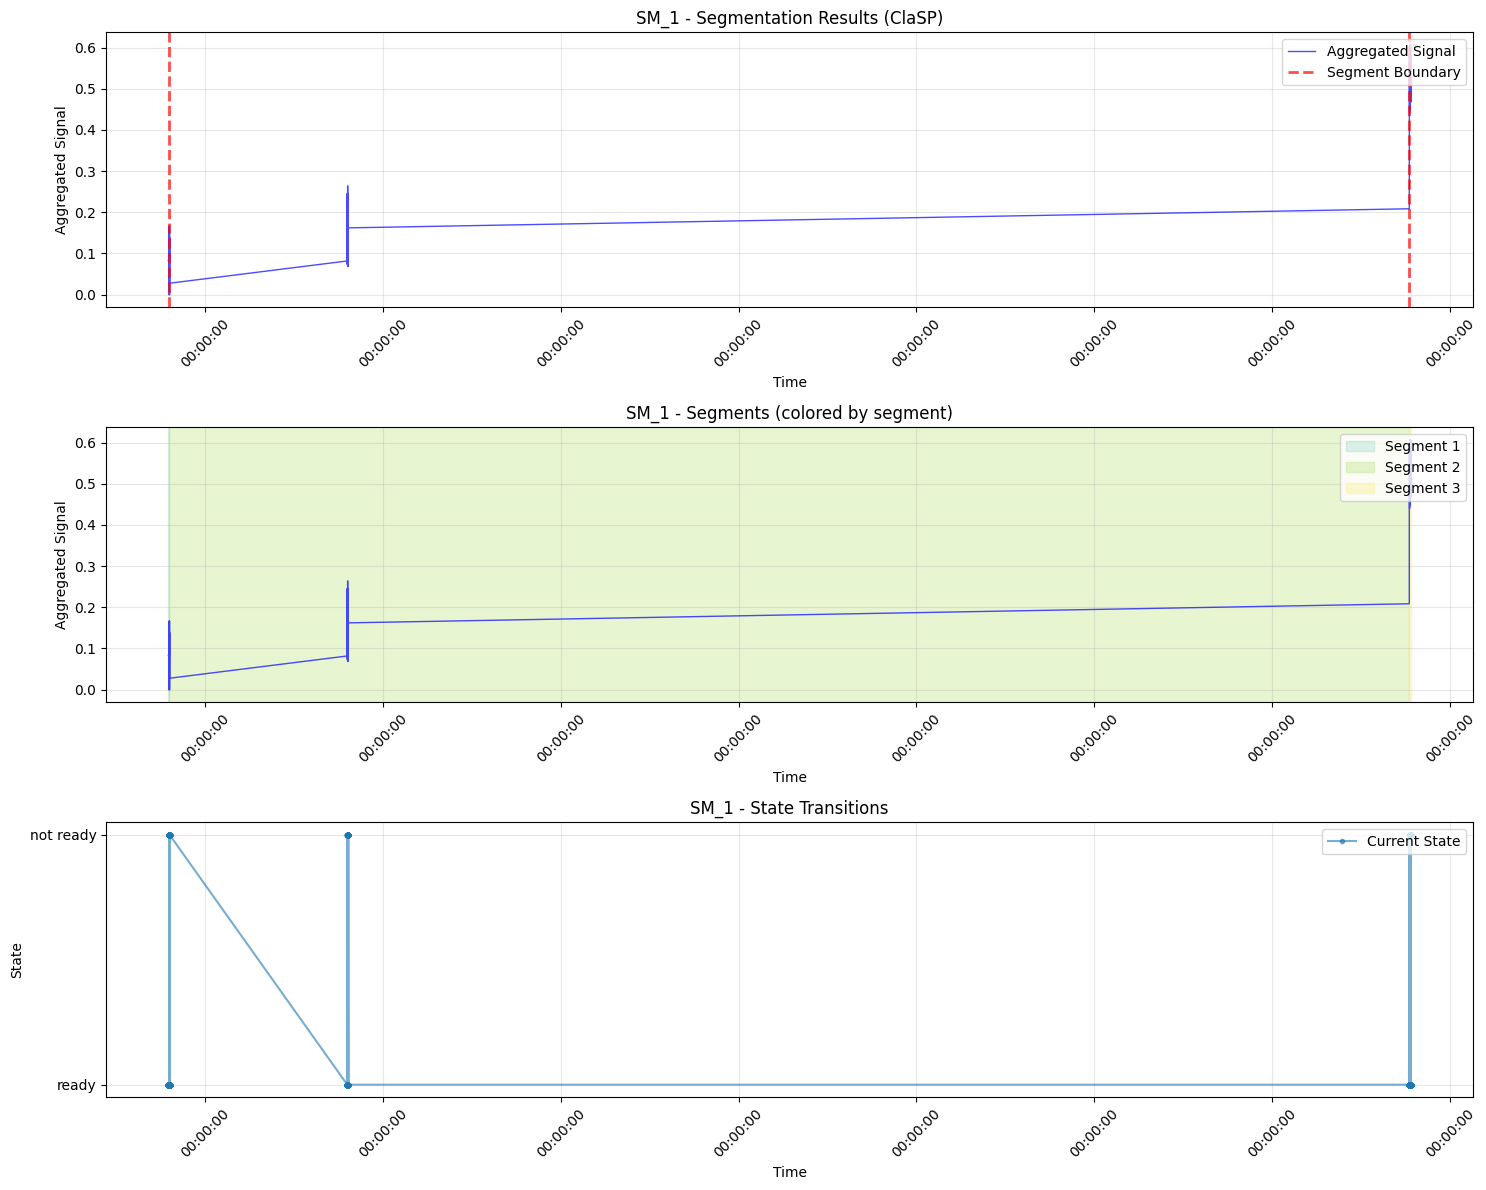


 Segmenting VGR_1...

   Segmenting VGR_1...
     Signal length: 5492
     Signal-aligned GT boundaries: 0
     Auto-detected 4 segments
     ClaSP boundaries: 4 segments

 Segment statistics:
   segment      mean       std       var
0        0  0.216560  0.053565  0.002869
1        1  0.223917  0.057372  0.003292
2        2  0.268314  0.055205  0.003048
3        3  0.422349  0.057227  0.003275

 Segment time ranges:
   segment  start_index  end_index              start_time  \
0        0            0        710 2023-01-30 13:06:20.820   
1        1          711       1575 2023-01-30 13:30:11.430   
2        2         1576       3430 2023-02-06 14:08:55.050   
3        3         3431       5491 2023-02-06 15:11:07.730   

                 end_time  
0 2023-01-30 13:30:09.430  
1 2023-02-06 14:08:53.000  
2 2023-02-06 15:11:05.720  
3 2023-03-20 11:10:51.770  
     Evaluating boundaries...

Segmentation credibility metrics:
separation_score: 0.863
stability_score: 0.003
boundary_streng

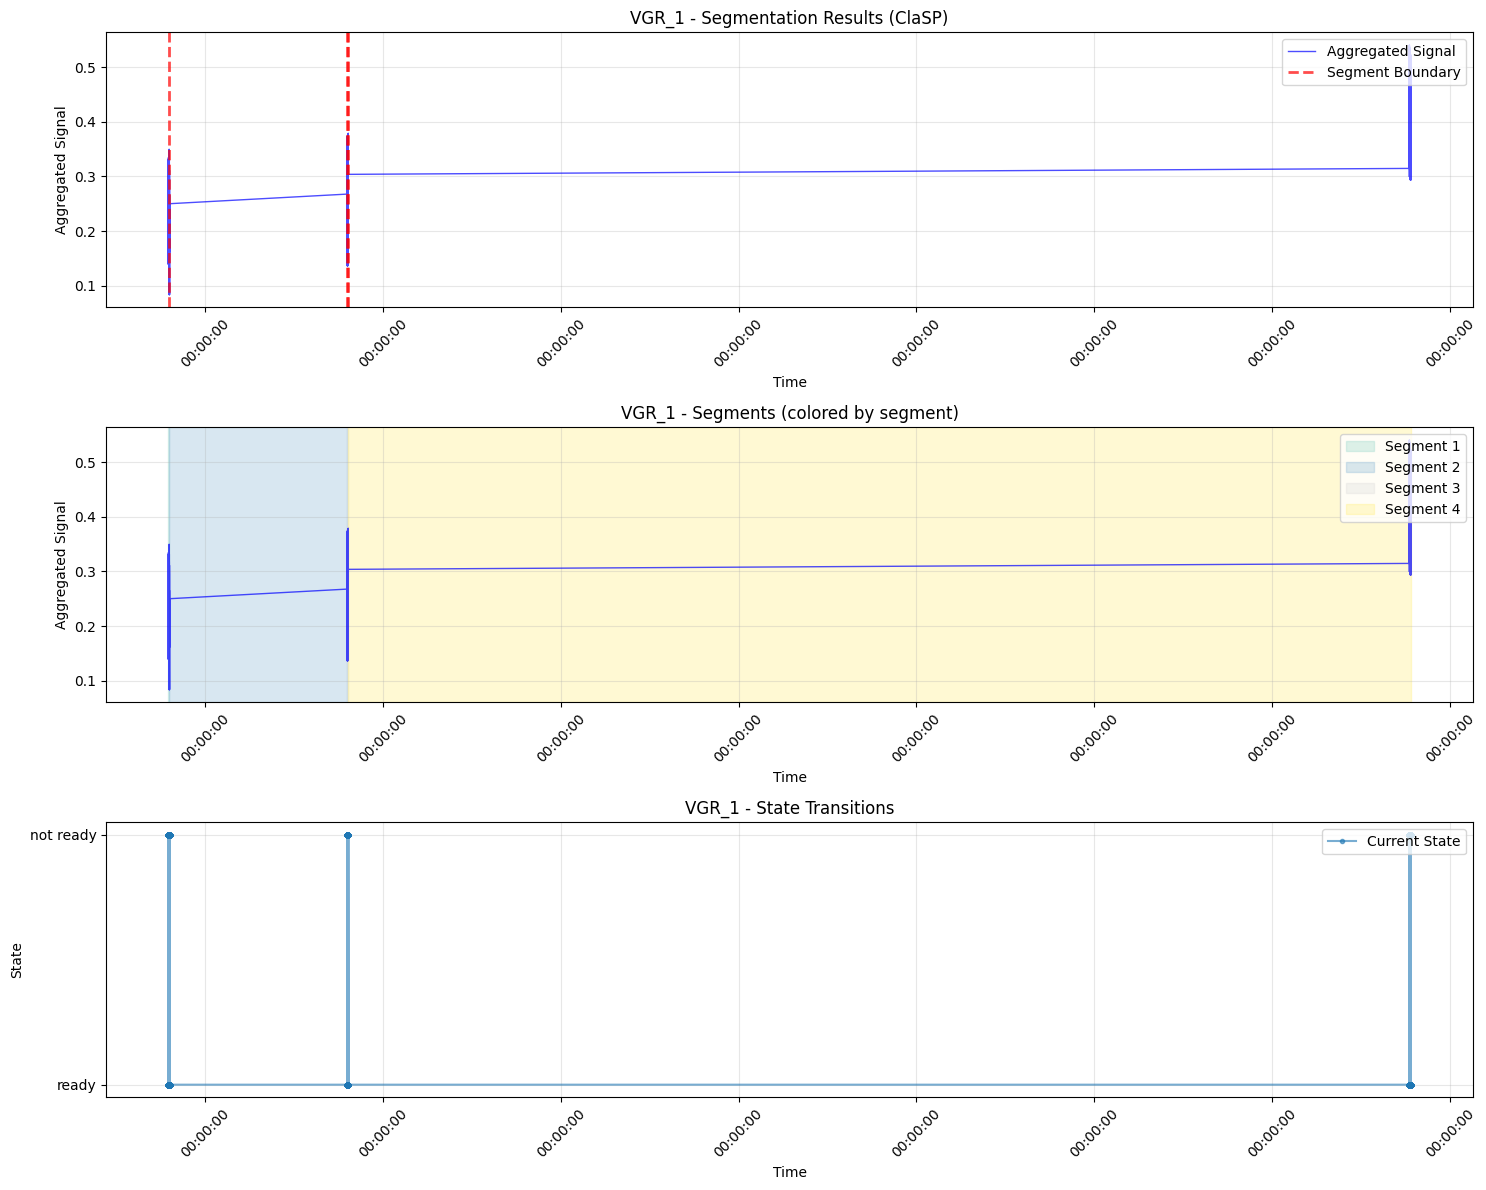


 Segmenting OV_1...

   Segmenting OV_1...
     Signal length: 5500
     Signal-aligned GT boundaries: 0
     Auto-detected 3 segments
     ClaSP boundaries: 3 segments

 Segment statistics:
   segment      mean       std       var
0        0  0.078141  0.029584  0.000875
1        1  0.211840  0.045688  0.002087
2        2  0.225161  0.044462  0.001977

 Segment time ranges:
   segment  start_index  end_index              start_time  \
0        0            0       3419 2023-01-30 13:06:20.910   
1        1         3420       3857 2023-02-06 15:10:36.400   
2        2         3858       5499 2023-03-20 09:59:35.980   

                 end_time  
0 2023-02-06 15:10:34.390  
1 2023-03-20 09:59:33.970  
2 2023-03-20 11:10:52.270  
     Evaluating boundaries...

Segmentation credibility metrics:
separation_score: 1.333
stability_score: 0.002
boundary_strength: 0.000
explained_variance: 0.735
     Segmentation complete for OV_1
separation_score: 1.333
stability_score: 0.002
boundary_stren

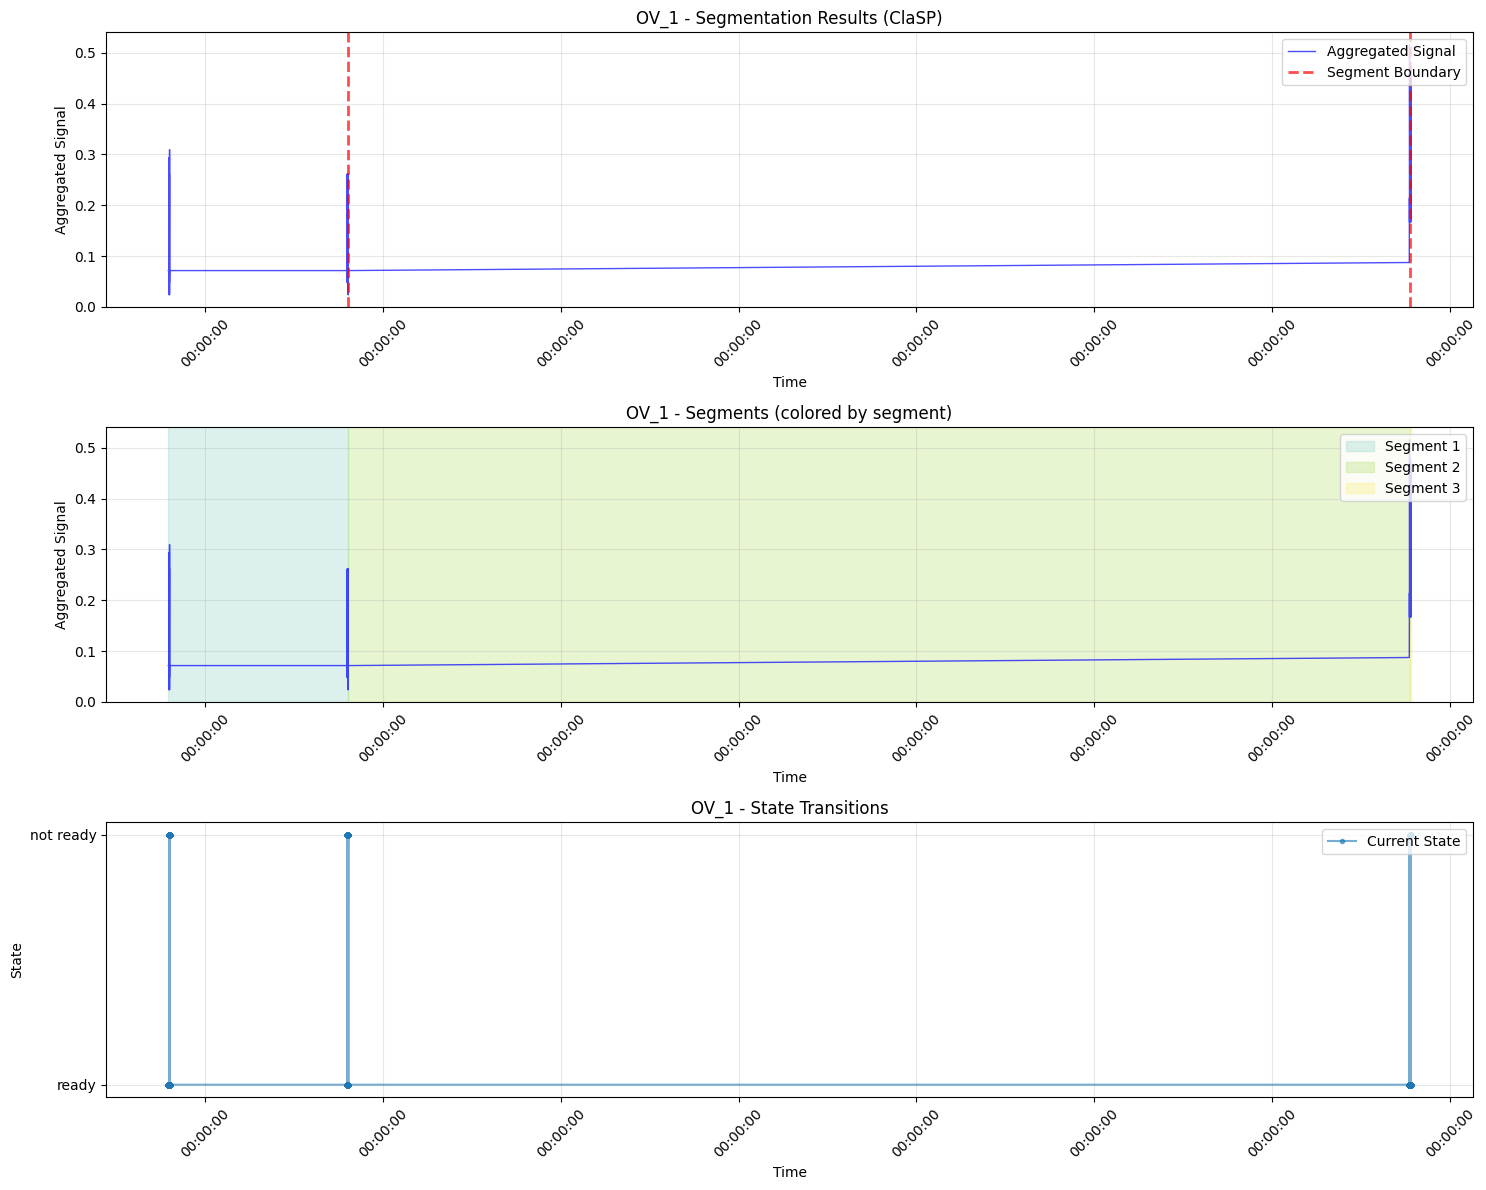


 Segmenting WT_1...

   Segmenting WT_1...
     Signal length: 5501
     Signal-aligned GT boundaries: 0
     Auto-detected 2 segments
     ClaSP boundaries: 2 segments

 Segment statistics:
   segment      mean       std       var
0        0  0.074171  0.021495  0.000462
1        1  0.079228  0.044891  0.002015

 Segment time ranges:
   segment  start_index  end_index              start_time  \
0        0            0       3293 2023-01-30 13:06:20.910   
1        1         3294       5500 2023-02-06 15:06:21.300   

                 end_time  
0 2023-02-06 15:06:19.290  
1 2023-03-20 11:10:52.270  
     Evaluating boundaries...

Segmentation credibility metrics:
separation_score: 0.102
stability_score: 0.001
boundary_strength: 0.000
explained_variance: -0.135
     Segmentation complete for WT_1
separation_score: 0.102
stability_score: 0.001
boundary_strength: 0.000
explained_variance: -0.135

 Generating inline visualization for WT_1...


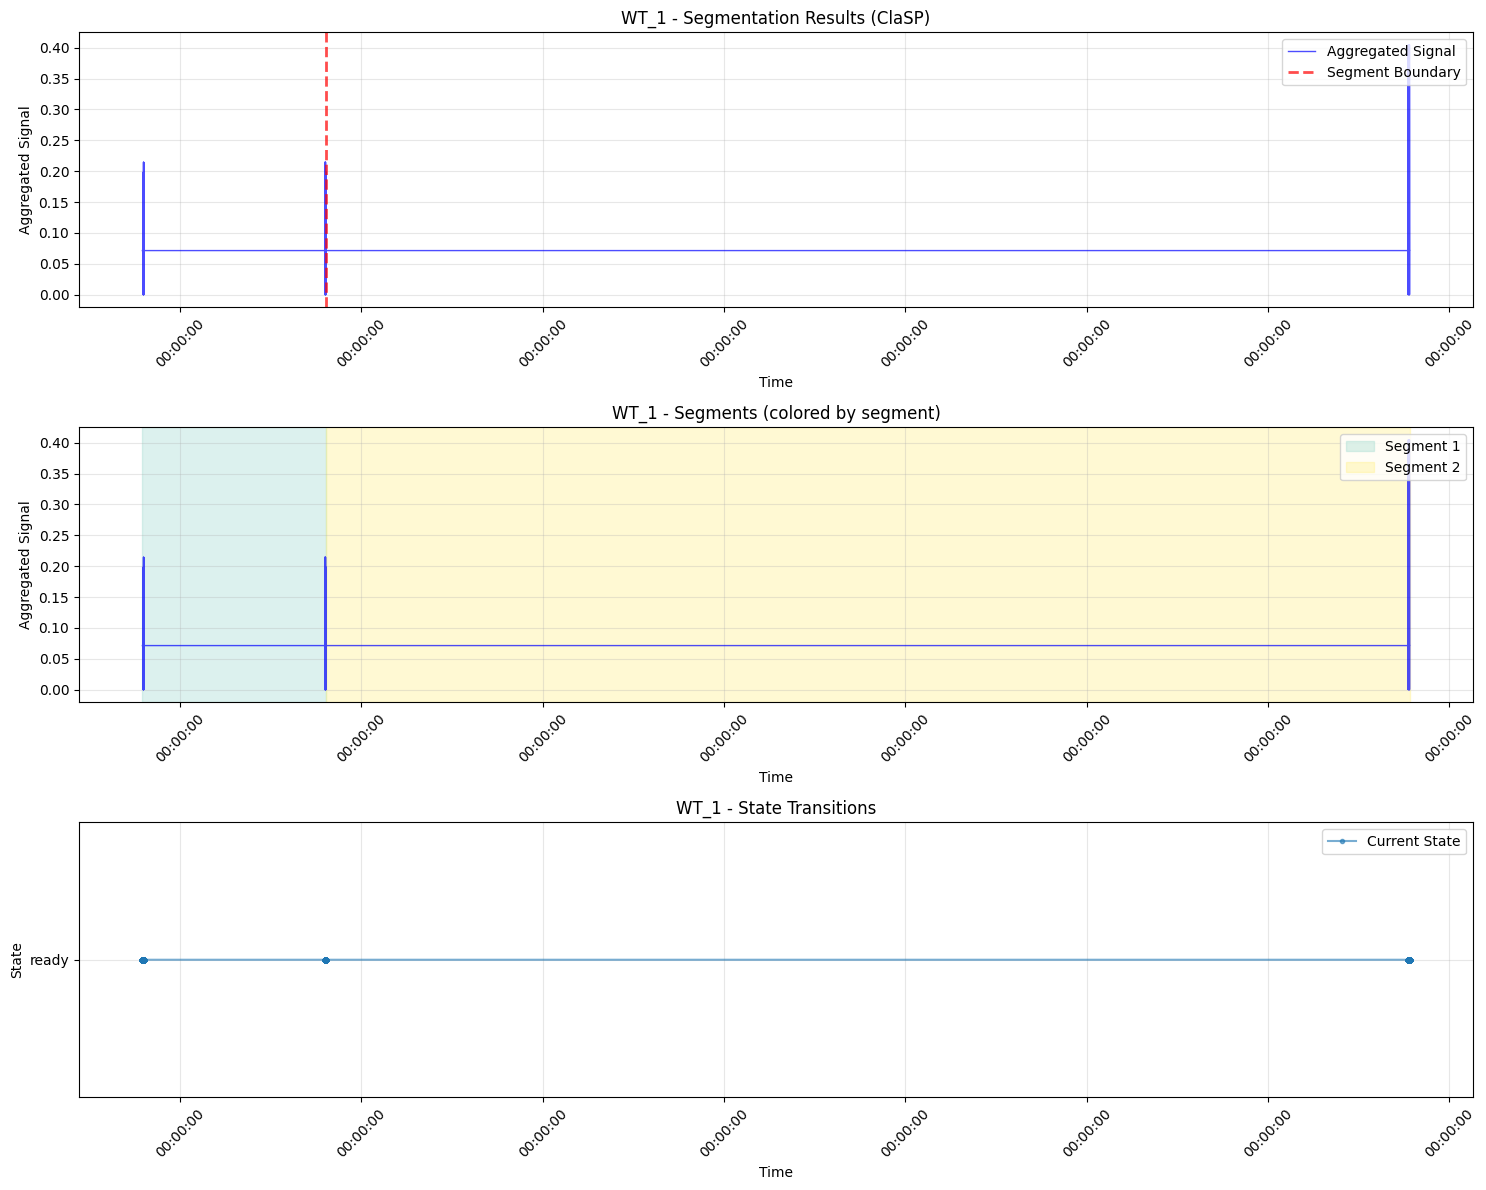


TASK 4: PIPELINE INTEGRATION & EXPORT
   Exported 3 segments to segmentation_output\MM_1_segments.json
   Exported 3 segments for MM_1
   Sample segment for MM_1:
    Segment ID: 1
    Length: 3080 samples
    Dominant State: ready
    Features: 26 sensor statistics
   Exported 5 segments to segmentation_output\HBW_1_segments.json
   Exported 5 segments for HBW_1
   Sample segment for HBW_1:
    Segment ID: 1
    Length: 752 samples
    Dominant State: not ready
    Features: 42 sensor statistics
   Exported 1 segments to segmentation_output\EC_1_segments.json
   Exported 1 segments for EC_1
   Sample segment for EC_1:
    Segment ID: 1
    Length: 5503 samples
    Dominant State: ready
    Features: 22 sensor statistics
   Exported 3 segments to segmentation_output\SM_1_segments.json
   Exported 3 segments for SM_1
   Sample segment for SM_1:
    Segment ID: 1
    Length: 1236 samples
    Dominant State: ready
    Features: 30 sensor statistics
   Exported 4 segments to segmentation_

In [11]:
# ============================================================================
# RUN THE COMPLETE PIPELINE
# ============================================================================

print(" Starting IoT Segmentation Pipeline...")
print("=" * 60)

try:
    # Run the complete pipeline with inline visualization
    results = run_complete_pipeline(
        data_dir="data/data-radiant-eval-paper/factory/evaluation/iot_logs",
        output_dir="segmentation_output",
        stations_to_process=None,  # Process all stations
        visualize_inline=True
    )
    
    print("\n" + "=" * 60)
    print(" SUCCESS: Pipeline completed successfully!")
    print("=" * 60)
    print("\n Output files are in the 'segmentation_output' directory:")
    print("   segmentation_summary.json: Overall summary")
    print("   {station}_segments.json: CBR-ready segments per station")
    print("   Visualizations: Displayed inline above")
    
except Exception as e:
    print(f"\n ERROR: Pipeline failed with error: {e}")
    import traceback
    traceback.print_exc()

ANALYZING RESULTS

 OVERALL RESULTS:
Total stations processed: 7
Total segments created: 21

 DETAILED METRICS PER STATION:

MM_1:
  separation_score:  1.223
  stability_score:     0.001
  boundary_strength:   0.000
  explained_variance:   0.747
  Segments:   3

HBW_1:
  separation_score:  0.268
  stability_score:     0.002
  boundary_strength:   0.005
  explained_variance:   0.174
  Segments:   5

EC_1:
  separation_score:  nan
  stability_score:     0.001
  boundary_strength:   nan
  explained_variance:   0.000
  Segments:   1

SM_1:
  separation_score:  1.630
  stability_score:     0.008
  boundary_strength:   0.000
  explained_variance:   0.842
  Segments:   3

VGR_1:
  separation_score:  0.863
  stability_score:     0.003
  boundary_strength:   0.020
  explained_variance:   0.710
  Segments:   4

OV_1:
  separation_score:  1.333
  stability_score:     0.002
  boundary_strength:   0.000
  explained_variance:   0.735
  Segments:   3

WT_1:
  separation_score:  0.102
  stability_scor

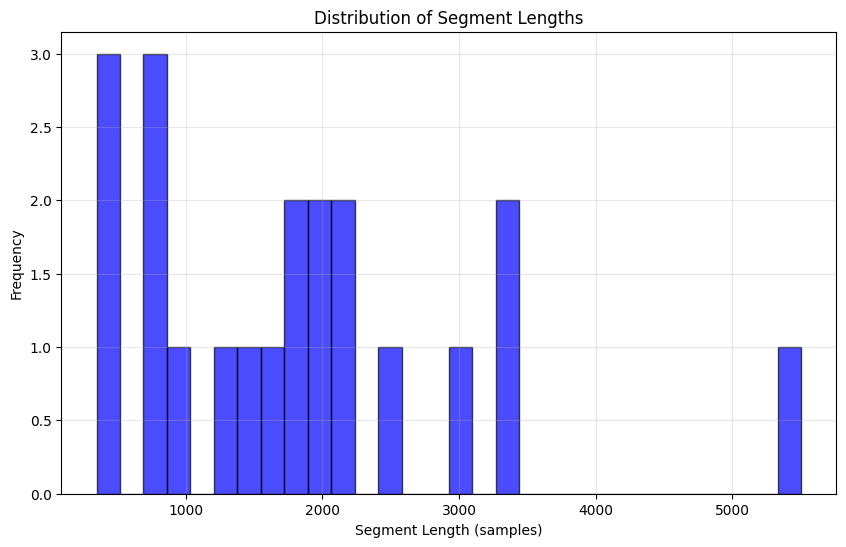

In [12]:
# ============================================================================
# ANALYZE RESULTS
# ============================================================================

if 'results' in locals():
    print("=" * 60)
    print("ANALYZING RESULTS")
    print("=" * 60)
    
    summary = results['summary']
    all_segments = results['all_segments']
    
    print(f"\n OVERALL RESULTS:")
    print(f"Total stations processed: {summary['total_stations']}")
    print(f"Total segments created: {summary['total_segments']}")
    
    # Show detailed metrics
    print(f"\n DETAILED METRICS PER STATION:")
    for station, metrics in summary['evaluation_metrics'].items():
        print(f"\n{station}:")
        print(f"  separation_score:  {metrics['separation_score']:.3f}")
        print(f"  stability_score:     {metrics['stability_score']:.3f}")
        print(f"  boundary_strength:   {metrics['boundary_strength']:.3f}")
        print(f"  explained_variance:   {metrics['explained_variance']:.3f}")
        print(f"  Segments:   {len(all_segments.get(station, []))}")
    
    # Show segment statistics
    print(f"\n SEGMENT STATISTICS:")
    all_segment_lengths = []
    for station, segments in all_segments.items():
        segment_lengths = [seg['length'] for seg in segments]
        all_segment_lengths.extend(segment_lengths)
        if segment_lengths:
            print(f"{station}: Min={min(segment_lengths):.0f}, "
                  f"Max={max(segment_lengths):.0f}, "
                  f"Avg={np.mean(segment_lengths):.0f} samples")
    
    if all_segment_lengths:
        print(f"\n OVERALL SEGMENT LENGTHS:")
        print(f"Min: {min(all_segment_lengths):.0f} samples")
        print(f"Max: {max(all_segment_lengths):.0f} samples")
        print(f"Average: {np.mean(all_segment_lengths):.0f} samples")
        print(f"Median: {np.median(all_segment_lengths):.0f} samples")
        
        # Plot segment length distribution
        plt.figure(figsize=(10, 6))
        plt.hist(all_segment_lengths, bins=30, alpha=0.7, color='blue', edgecolor='black')
        plt.xlabel('Segment Length (samples)')
        plt.ylabel('Frequency')
        plt.title('Distribution of Segment Lengths')
        plt.grid(True, alpha=0.3)
        plt.show()

# Complete Code

# Industrial IoT Data Segmentation Pipeline

This pipeline implements **ClaSP (Classification Score Profile)** for unsupervised, parameter-free segmentation of industrial IoT sensor data as a prerequisite for Case-Based Reasoning (CBR) activity detection.

## Overview

The pipeline processes JSONL files containing IoT sensor data from multiple manufacturing stations and performs:

1. **Data Loading & Exploration**: Loads all JSONL files, parses timestamps, handles mixed types, splits by station
2. **Feature Engineering**: Station-specific feature selection, type conversion, missing value handling, temporal features, signal aggregation
3. **Segmentation**: ClaSP-based segmentation with baseline comparison (PELT)
4. **Evaluation**: Boundary precision metrics against state changes
5. **Export**: CBR-ready segment data in JSON format

In [13]:
# Jupyter Notebook: Industrial IoT Data Segmentation Pipeline
# This notebook implements ClaSP for unsupervised segmentation of industrial IoT sensor data

# Import all required libraries
import json
import pandas as pd
import numpy as np
from pathlib import Path
from typing import Dict, List, Tuple, Optional
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Segmentation libraries
try:
    from claspy.segmentation import ClaSPEnsemble, BinaryClaSPSegmentation
except ImportError:
    try:
        from claspy import ClaSPEnsemble, BinaryClaSPSegmentation
    except ImportError:
        print("Warning: claspy not found. Install with: pip install claspy==0.2.7")
        ClaSPEnsemble = None
        BinaryClaSPSegmentation = None

try:
    import ruptures as rpt
except ImportError:
    print("Warning: ruptures not found. Install with: pip install ruptures")
    rpt = None

from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# For Jupyter display
%matplotlib inline

In [14]:
# ============================================================================
# TASK 1: DATA LOADING & EXPLORATION
# ============================================================================

class IoTDataLoader:
    """Load and preprocess IoT JSONL files with mixed station data."""
    
    def __init__(self, data_dir: str = "data/data-radiant-eval-paper/factory/evaluation/iot_logs"):
        self.data_dir = Path(data_dir)
        self.raw_data = None
        self.processed_data = None
        self.station_data = {}
        
    def load_all_files(self, file_pattern: str = "*.jsonl") -> pd.DataFrame:
        """
        Load all JSONL files from data directory.
        
        Returns:
            Unified DataFrame with all records
        """
        jsonl_files = sorted(self.data_dir.glob(file_pattern))
        
        if not jsonl_files:
            raise FileNotFoundError(f"No JSONL files found in {self.data_dir}")
        
        print(f"Loading {len(jsonl_files)} JSONL files...")
        
        all_records = []
        for file_path in jsonl_files:
            print(f"  Loading {file_path.name}...")
            with open(file_path, 'r', encoding='utf-8') as f:
                for line_num, line in enumerate(f, 1):
                    try:
                        record = json.loads(line.strip())
                        record['source_file'] = file_path.name
                        all_records.append(record)
                    except json.JSONDecodeError as e:
                        print(f"    Warning: Skipping invalid JSON at line {line_num} in {file_path.name}: {e}")
        
        self.raw_data = pd.DataFrame(all_records)
        print(f"Loaded {len(self.raw_data)} total records")
        
        return self.raw_data
    
    def parse_timestamps(self, df: pd.DataFrame) -> pd.DataFrame:
        """Parse timestamp strings to datetime objects."""
        if 'timestamp' in df.columns:
            df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')
            # Sort by timestamp for temporal analysis
            df = df.sort_values('timestamp').reset_index(drop=True)
        return df
    
    def handle_mixed_types(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Convert string numbers to numeric types.
        Handles fields like "0.00" that should be numeric.
        """
        df = df.copy()
        
        for col in df.columns:
            if col in ['id', 'station', 'timestamp', 'current_state', 'current_task', 
                      'current_sub_task', 'source_file', 'hbw1_current_stock']:
                continue
            
            # Try to convert to numeric
            if df[col].dtype == 'object':
                # Check if values are numeric strings
                sample = df[col].dropna().head(10)
                if len(sample) > 0:
                    try:
                        # Try converting first non-null value
                        test_val = sample.iloc[0]
                        if isinstance(test_val, str) and test_val.replace('.', '').replace('-', '').isdigit():
                            df[col] = pd.to_numeric(df[col], errors='coerce')
                    except:
                        pass
        
        return df
    
    def expand_nested_structures(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Expand nested JSON structures (e.g., hbw1_current_stock).
        For now, we'll extract key information or flatten if needed.
        """
        df = df.copy()
        
        # Handle hbw1_current_stock nested structure
        if 'hbw1_current_stock' in df.columns:
            # Count non-empty stock positions
            def count_stock_items(stock_dict):
                if isinstance(stock_dict, dict):
                    return sum(1 for v in stock_dict.values() if v and str(v).strip())
                return 0
            
            df['hbw1_stock_count'] = df['hbw1_current_stock'].apply(count_stock_items)
            # Drop the nested column for now (can be expanded later if needed)
            df = df.drop(columns=['hbw1_current_stock'], errors='ignore')
        
        return df
    
    def split_by_station(self, df: pd.DataFrame) -> Dict[str, pd.DataFrame]:
        """
        Split unified DataFrame by station for individual analysis.
        
        Returns:
            Dictionary mapping station names to DataFrames
        """
        if 'station' not in df.columns:
            raise ValueError("DataFrame must have 'station' column")
        
        station_data = {}
        for station in df['station'].unique():
            station_df = df[df['station'] == station].copy()
            station_df = station_df.sort_values('timestamp').reset_index(drop=True)
            station_data[station] = station_df
            print(f"  Station {station}: {len(station_df)} records")
        
        self.station_data = station_data
        return station_data
    
    def get_diagnostics(self, df: pd.DataFrame) -> Dict:
        """
        Provide basic diagnostics: time ranges, missing values, sensor distributions.
        
        Returns:
            Dictionary with diagnostic information
        """
        diagnostics = {
            'total_records': len(df),
            'stations': df['station'].value_counts().to_dict() if 'station' in df.columns else {},
            'time_range': {},
            'missing_values': {},
            'sensor_info': {}
        }
        
        # Time range per station
        if 'timestamp' in df.columns and 'station' in df.columns:
            for station in df['station'].unique():
                station_df = df[df['station'] == station]
                if not station_df['timestamp'].isna().all():
                    diagnostics['time_range'][station] = {
                        'start': station_df['timestamp'].min(),
                        'end': station_df['timestamp'].max(),
                        'duration_hours': (station_df['timestamp'].max() - station_df['timestamp'].min()).total_seconds() / 3600
                    }
        
        # Missing values
        sensor_cols = [col for col in df.columns if col not in 
                      ['id', 'station', 'timestamp', 'current_state', 'current_task', 
                       'current_sub_task', 'source_file', 'hbw1_current_stock']]
        
        for col in sensor_cols:
            missing_count = df[col].isna().sum()
            if missing_count > 0:
                diagnostics['missing_values'][col] = {
                    'count': int(missing_count),
                    'percentage': float(missing_count / len(df) * 100)
                }
        
        # Sensor distributions (basic stats)
        for col in sensor_cols:
            if df[col].dtype in ['int64', 'float64']:
                diagnostics['sensor_info'][col] = {
                    'dtype': str(df[col].dtype),
                    'min': float(df[col].min()) if not df[col].isna().all() else None,
                    'max': float(df[col].max()) if not df[col].isna().all() else None,
                    'mean': float(df[col].mean()) if not df[col].isna().all() else None,
                    'unique_values': int(df[col].nunique())
                }
        
        return diagnostics
    
    def process_all(self) -> pd.DataFrame:
        """Complete data loading and preprocessing pipeline."""
        print("=" * 60)
        print("TASK 1: DATA LOADING & EXPLORATION")
        print("=" * 60)
        
        # Load files
        df = self.load_all_files()
        
        # Parse timestamps
        print("\nParsing timestamps...")
        df = self.parse_timestamps(df)
        
        # Handle mixed types
        print("Handling mixed numeric types...")
        df = self.handle_mixed_types(df)
        
        # Expand nested structures
        print("Expanding nested structures...")
        df = self.expand_nested_structures(df)
        
        # Split by station
        print("\nSplitting data by station...")
        self.split_by_station(df)
        
        # Diagnostics
        print("\nGenerating diagnostics...")
        diagnostics = self.get_diagnostics(df)
        
        print("\n" + "=" * 60)
        print("DIAGNOSTICS SUMMARY")
        print("=" * 60)
        print(f"Total records: {diagnostics['total_records']}")
        print(f"\nStations: {list(diagnostics['stations'].keys())}")
        for station, count in diagnostics['stations'].items():
            print(f"  {station}: {count} records")
        
        print(f"\nTime ranges:")
        for station, tr in diagnostics['time_range'].items():
            print(f"  {station}:")
            print(f"    Start: {tr['start']}")
            print(f"    End: {tr['end']}")
            print(f"    Duration: {tr['duration_hours']:.2f} hours")
        
        if diagnostics['missing_values']:
            print(f"\nMissing values (top 10):")
            sorted_missing = sorted(diagnostics['missing_values'].items(), 
                                  key=lambda x: x[1]['count'], reverse=True)[:10]
            for col, info in sorted_missing:
                print(f"  {col}: {info['count']} ({info['percentage']:.2f}%)")
        else:
            print("\nNo missing values detected in sensor columns.")
        
        self.processed_data = df
        return df

In [15]:
# ============================================================================
# TASK 2: FEATURE ENGINEERING & STANDARDIZATION
# ============================================================================

class FeatureEngineer:
    """Feature engineering for station-specific sensor data."""
    
    def __init__(self):
        self.scalers = {}
        self.feature_configs = {}
    
    def get_station_sensors(self, df: pd.DataFrame, station: str) -> List[str]:
        """Extract station-specific sensor column names."""
        station_prefix = station.lower().replace('_', '')
        sensor_cols = []
        
        for col in df.columns:
            # Skip metadata columns
            if col in ['id', 'station', 'timestamp', 'current_state', 'current_task',
                      'current_sub_task', 'source_file', 'hbw1_current_stock']:
                continue
            
            # Check if column belongs to this station
            col_lower = col.lower()
            if col_lower.startswith(station_prefix) or col_lower.startswith(station_prefix[:3]):
                sensor_cols.append(col)
        
        return sensor_cols
    
    def classify_sensor_type(self, df: pd.DataFrame, col: str) -> str:
        """
        Classify sensor as binary, continuous, or position.
        
        Returns:
            'binary', 'continuous', 'position', or 'other'
        """
        if df[col].isna().all():
            return 'other'
        
        unique_vals = df[col].dropna().unique()
        n_unique = len(unique_vals)
        
        # Binary sensors (0/1 or True/False)
        if n_unique <= 2 and all(v in [0, 1, True, False, 0.0, 1.0] for v in unique_vals):
            return 'binary'
        
        # Position coordinates
        if 'pos' in col.lower() and ('x' in col.lower() or 'y' in col.lower() or 'z' in col.lower()):
            return 'position'
        
        # Continuous sensors (speeds, photoresistor, color sensors, etc.)
        return 'continuous'
    
    def create_temporal_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Create temporal features: time since last event, rate of change.
        """
        df = df.copy()
        df = df.sort_values('timestamp').reset_index(drop=True)
        
        # Time since last event (in seconds)
        if 'timestamp' in df.columns:
            df['time_since_last'] = df['timestamp'].diff().dt.total_seconds().fillna(0)
            df['time_since_last'] = df['time_since_last'].clip(upper=3600)  # Cap at 1 hour
        
        return df
    
    def aggregate_signals(self, df: pd.DataFrame, sensor_cols: List[str], 
                         station: str) -> pd.Series:
        """
        Create 1D aggregated signal for segmentation.
        
        Strategy:
        - Binary sensors: Keep as 0/1, use mean
        - Continuous sensors: Normalize and use mean
        - Position sensors: Use distance from origin or change detection
        
        Returns:
            1D time series for segmentation
        """
        if len(sensor_cols) == 0:
            raise ValueError(f"No sensor columns found for station {station}")
        
        # Classify sensors
        sensor_types = {col: self.classify_sensor_type(df, col) for col in sensor_cols}
        
        # Prepare normalized features
        normalized_features = []
        
        for col in sensor_cols:
            if df[col].isna().all():
                continue
            
            sensor_type = sensor_types[col]
            values = df[col].fillna(0).values
            
            if sensor_type == 'binary':
                # Binary sensors: keep as 0/1
                normalized_features.append(values)
            
            elif sensor_type == 'continuous':
                # Continuous sensors: normalize to [0, 1]
                if values.max() > values.min():
                    normalized = (values - values.min()) / (values.max() - values.min())
                else:
                    normalized = values
                normalized_features.append(normalized)
            
            elif sensor_type == 'position':
                # Position sensors: use absolute value or distance
                # For simplicity, use absolute value normalized
                abs_values = np.abs(values)
                if abs_values.max() > abs_values.min():
                    normalized = (abs_values - abs_values.min()) / (abs_values.max() - abs_values.min())
                else:
                    normalized = abs_values
                normalized_features.append(normalized)
        
        if len(normalized_features) == 0:
            # Fallback: use all numeric columns
            numeric_cols = df[sensor_cols].select_dtypes(include=[np.number]).columns
            if len(numeric_cols) > 0:
                for col in numeric_cols:
                    values = df[col].fillna(0).values
                    if values.max() > values.min():
                        normalized = (values - values.min()) / (values.max() - values.min())
                    else:
                        normalized = values
                    normalized_features.append(normalized)
            else:
                raise ValueError(f"No valid sensor data for station {station}")
        
        if len(normalized_features) == 0:
            raise ValueError(f"No valid normalized features for station {station}")
        
        # Aggregate: mean of normalized features
        aggregated = np.mean(normalized_features, axis=0)
        
        # Ensure no NaN or Inf values
        aggregated = np.nan_to_num(aggregated, nan=0.0, posinf=1.0, neginf=0.0)
        
        return pd.Series(aggregated, index=df.index)
    
    def engineer_features(self, df: pd.DataFrame, station: str) -> Tuple[pd.DataFrame, pd.Series]:
        """
        Complete feature engineering for a station.
        
        Returns:
            (processed_df, aggregated_signal)
        """
        df = df.copy()
        
        # Get station-specific sensors
        sensor_cols = self.get_station_sensors(df, station)
        print(f"  Found {len(sensor_cols)} sensor columns for {station}")
        
        # Ensure all sensors are numeric
        for col in sensor_cols:
            if df[col].dtype == 'object':
                df[col] = pd.to_numeric(df[col], errors='coerce')
            df[col] = df[col].fillna(0)  # Fill missing with 0
        
        # Create temporal features
        df = self.create_temporal_features(df)
        
        # Create aggregated 1D signal
        aggregated_signal = self.aggregate_signals(df, sensor_cols, station)
        
        return df, aggregated_signal

In [16]:
# ============================================================================
# TASK 3: SEGMENTATION IMPLEMENTATION
# ============================================================================

class Segmenter:
    """ClaSP-based segmentation with baseline comparison."""
    
    def __init__(self):
        self.segments = {}
        self.baseline_segments = {}
    
    def _recursive_binary_segmentation(self, signal_array: np.ndarray, n_segments: int, 
                                      window_size: str = "suss") -> np.ndarray:
        """
        Recursively apply binary segmentation using ClaSPEnsemble to get multiple segments.
        This is a fallback method.
        """
        if ClaSPEnsemble is None:
            raise ImportError("ClaSPEnsemble not available")
        
        change_points = []
        segments_to_find = n_segments - 1
        
        # Recursively split segments
        segments_to_split = [(0, len(signal_array))]
        
        while len(change_points) < segments_to_find and len(segments_to_split) > 0:
            start, end = segments_to_split.pop(0)
            if end - start < 20:  # Too short to split
                continue
            
            segment = signal_array[start:end]
            try:
                ensemble = ClaSPEnsemble(window_size=window_size)
                ensemble.fit(segment)
                cp = ensemble.split(sparse=True)
                if cp is not None and 0 < cp < len(segment):
                    global_cp = start + cp
                    change_points.append(global_cp)
                    # Add new segments to split
                    segments_to_split.append((start, global_cp))
                    segments_to_split.append((global_cp, end))
            except:
                continue
        
        return np.array(sorted(change_points))
    
    def segment_clasp_ensemble(self, signal: pd.Series, n_segments: Optional[int] = None,
                               window_size: str = "suss") -> np.ndarray:
        """
        Apply ClaSP Ensemble segmentation.
        
        Args:
            signal: 1D time series
            n_segments: Number of segments (if None, auto-detect)
            window_size: Window size parameter ("suss" for default)
        
        Returns:
            Array of change point indices
        """
        if ClaSPEnsemble is None:
            raise ImportError("claspy library not available. Install with: pip install claspy==0.2.7")
        
        if len(signal) < 10:
            # Too short for segmentation, return single segment
            return np.array([0, len(signal)])
        
        # Check for constant signal
        if signal.nunique() <= 1:
            # Constant signal, return single segment
            return np.array([0, len(signal)])
        
        signal_array = signal.values.reshape(-1, 1)  # ClaSP expects 2D
        
        if n_segments is None:
            # Auto-detect number of segments using binary segmentation
            try:
                # Use BinaryClaSPSegmentation with n_segments='learn' for auto-detection
                binary_seg = BinaryClaSPSegmentation(n_segments='learn', window_size=window_size)
                # Use fit_predict (standard method)
                change_points = binary_seg.fit_predict(signal_array)
                
                if isinstance(change_points, (int, np.integer)):
                    change_points = [change_points]
                change_points = np.array(change_points).flatten()
                n_segments = len(change_points) + 1
                print(f"    Auto-detected {n_segments} segments")
            except Exception as e:
                # Fallback: use heuristic
                n_segments = max(2, min(10, len(signal) // 100))
                print(f"    Using heuristic: {n_segments} segments (auto-detect failed: {e})")
        
        # Apply ClaSP segmentation
        # Use BinaryClaSPSegmentation for multiple segments (it accepts n_segments)
        # ClaSPEnsemble is only for binary segmentation (2 segments)
        change_points = None
        try:
            # Use BinaryClaSPSegmentation which supports n_segments parameter
            binary_seg = BinaryClaSPSegmentation(n_segments=n_segments, window_size=window_size)
            
            # Try fit_predict (standard method)
            try:
                change_points = binary_seg.fit_predict(signal_array)
            except (TypeError, AttributeError):
                # Fallback: try fit then predict
                try:
                    binary_seg.fit(signal_array)
                    change_points = binary_seg.predict()
                except:
                    # Last resort: try with 1D signal
                    change_points = binary_seg.fit_predict(signal.values)
                    
        except Exception as e1:
            # If BinaryClaSPSegmentation fails, try recursive binary segmentation with ClaSPEnsemble
            try:
                print(f"    Warning: BinaryClaSPSegmentation failed, using recursive binary segmentation")
                change_points = self._recursive_binary_segmentation(signal_array, n_segments, window_size)
            except Exception as e2:
                raise RuntimeError(f"ClaSP segmentation failed: {e1}, {e2}")
        
        # Ensure change_points is a list/array
        if change_points is None:
            raise ValueError("Failed to get change points from ClaSP")
        
        if isinstance(change_points, (int, np.integer)):
            change_points = [change_points]
        change_points = np.array(change_points).flatten()
        
        # Remove any invalid indices
        change_points = change_points[(change_points > 0) & (change_points < len(signal))]
        change_points = np.unique(change_points)  # Remove duplicates
        
        # Convert to indices (ClaSP returns change points, we need segment boundaries)
        boundaries = [0] + sorted(change_points.tolist()) + [len(signal)]
        boundaries = np.unique(boundaries)  # Ensure unique boundaries
        
        return np.array(boundaries)
    
    def segment_baseline_pelt(self, signal: pd.Series, n_segments: Optional[int] = None) -> np.ndarray:
        """
        Baseline segmentation using PELT (ruptures library).
        
        Args:
            signal: 1D time series
            n_segments: Number of segments (if None, auto-detect)
        
        Returns:
            Array of segment boundary indices
        """
        if rpt is None:
            raise ImportError("ruptures library not available. Install with: pip install ruptures")
        
        signal_array = signal.values.reshape(-1, 1)
        
        # Use PELT algorithm (faster than Dynp for many segments)
        if n_segments is None:
            # Auto-detect using penalty (PELT is fast)
            algo = rpt.Pelt(model="rbf", min_size=2).fit(signal_array)
            change_points = algo.predict(pen=10)
        else:
            # For fixed number of segments, use Dynp but limit to reasonable number
            if n_segments > 20:
                # Too many segments, use PELT instead
                algo = rpt.Pelt(model="rbf", min_size=2).fit(signal_array)
                change_points = algo.predict(pen=10)
            else:
                # Use Dynp for small number of segments
                algo = rpt.Dynp(model="rbf", min_size=2, jump=5).fit(signal_array)  # jump=5 for speed
                change_points = algo.predict(n_bkps=n_segments - 1)
        
        boundaries = [0] + sorted(change_points) + [len(signal)]
        
        return np.array(boundaries)
    
    def evaluate_boundaries(self, boundaries: np.ndarray, state_changes: np.ndarray,
                           tolerance: int = 5) -> Dict:
        """
        Evaluate segmentation boundaries against state changes.
        
        Args:
            boundaries: Segment boundary indices
            state_changes: Indices where current_state changes
            tolerance: Tolerance window for matching (in samples)
        
        Returns:
            Dictionary with precision, recall, F1, and other metrics
        """
        if len(state_changes) == 0:
            pred_count = len(boundaries) - 2 if len(boundaries) > 2 else 0
            return {
                'precision': 0.0,
                'recall': 0.0,
                'f1': 0.0,
                'true_positives': 0,
                'false_positives': pred_count,
                'false_negatives': 0,
                'n_predicted': pred_count,
                'n_true': 0
            }
        
        # Remove first boundary (always 0) and last (always end)
        pred_boundaries = set(boundaries[1:-1])
        true_boundaries = set(state_changes)
        
        # Match boundaries within tolerance
        true_positives = 0
        matched_pred = set()
        matched_true = set()
        
        for pred_bp in pred_boundaries:
            for true_bp in true_boundaries:
                if abs(pred_bp - true_bp) <= tolerance and pred_bp not in matched_pred and true_bp not in matched_true:
                    true_positives += 1
                    matched_pred.add(pred_bp)
                    matched_true.add(true_bp)
                    break
        
        false_positives = len(pred_boundaries) - len(matched_pred)
        false_negatives = len(true_boundaries) - len(matched_true)
        
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0.0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0.0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
        
        return {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'true_positives': true_positives,
            'false_positives': false_positives,
            'false_negatives': false_negatives,
            'n_predicted': len(pred_boundaries),
            'n_true': len(true_boundaries)
        }
    
    def segment_station(self, df: pd.DataFrame, signal: pd.Series, station: str,
                       use_baseline: bool = True) -> Dict:
        """
        Segment a station's time series.
        
        Returns:
            Dictionary with segments and evaluation metrics
        """
        import sys
        sys.stdout.flush()  # Force output
        print(f"\n  Segmenting {station}...")
        sys.stdout.flush()
        print(f"    Signal length: {len(signal)}")
        sys.stdout.flush()
        
        # Detect state changes for evaluation
        if 'current_state' in df.columns:
            state_changes = []
            prev_state = None
            for idx, state in enumerate(df['current_state']):
                if prev_state is not None and state != prev_state:
                    state_changes.append(idx)
                prev_state = state
            state_changes = np.array(state_changes)
            print(f"    State changes detected: {len(state_changes)}")
            sys.stdout.flush()
        else:
            state_changes = np.array([])
        
        # Estimate number of segments based on state changes
        n_segments = max(2, len(state_changes) + 1) if len(state_changes) > 0 else None
        
        # ClaSP segmentation
        try:
            boundaries = self.segment_clasp_ensemble(signal, n_segments=n_segments)
            import sys
            sys.stdout.flush()  # Force output
            print(f"    ClaSP boundaries: {len(boundaries) - 1} segments")
            sys.stdout.flush()
        except Exception as e:
            print(f"    ClaSP failed: {e}")
            import traceback
            traceback.print_exc()
            # Fallback: simple equal-length segments
            n_segments = max(2, min(10, len(signal) // 100))
            boundaries = np.linspace(0, len(signal), n_segments + 1, dtype=int)
        
        # Baseline segmentation (if requested) - skip if too many segments (too slow)
        baseline_boundaries = None
        if use_baseline and rpt is not None:
            # Skip baseline if n_segments is too large (Dynp is very slow)
            if n_segments is not None and n_segments > 20:
                print(f"    Skipping baseline segmentation (too many segments: {n_segments}, would be too slow)")
            else:
                try:
                    print(f"    Running baseline segmentation (PELT)...")
                    import sys
                    sys.stdout.flush()  # Force output
                    baseline_boundaries = self.segment_baseline_pelt(signal, n_segments=n_segments)
                    print(f"    Baseline (PELT) boundaries: {len(baseline_boundaries) - 1} segments")
                    sys.stdout.flush()
                except Exception as e:
                    print(f"    Baseline segmentation failed: {e}")
                    import traceback
                    traceback.print_exc()
        # Debug output
        import sys
        sys.stdout.flush()  # Force output
        print(f"    Debug: boundaries shape={boundaries.shape}, state_changes shape={state_changes.shape}")
        sys.stdout.flush()
        print(f"    Debug: boundaries (first 10)={boundaries[:10] if len(boundaries) > 10 else boundaries}")
        sys.stdout.flush()
        print(f"    Debug: state_changes (first 10)={state_changes[:10] if len(state_changes) > 10 else state_changes}")
        sys.stdout.flush()
        
        # Evaluate boundaries
        print(f"    Evaluating boundaries...")
        sys.stdout.flush()
        try:
            metrics = self.evaluate_boundaries(boundaries, state_changes)
            print(f"    Evaluation complete: P={metrics['precision']:.3f}, R={metrics['recall']:.3f}, F1={metrics['f1']:.3f}")
        except Exception as e:
            print(f"    Error in evaluation: {e}")
            import traceback
            traceback.print_exc()
            # Use default metrics on error
            metrics = {
                'precision': 0.0,
                'recall': 0.0,
                'f1': 0.0,
                'true_positives': 0,
                'false_positives': 0,
                'false_negatives': 0,
                'n_predicted': len(boundaries) - 2,
                'n_true': len(state_changes)
            }
        
        print(f"    Creating result dictionary...")
        import sys
        sys.stdout.flush()
        result = {
            'station': station,
            'boundaries': boundaries,
            'baseline_boundaries': baseline_boundaries,
            'state_changes': state_changes,
            'metrics': metrics,
            'n_segments': len(boundaries) - 1
        }
        print(f"    Segmentation complete for {station}")
        sys.stdout.flush()
        return result

In [17]:
# ============================================================================
# TASK 4: PIPELINE INTEGRATION & EXPORT
# ============================================================================

class CBRExporter:
    """Export segments in CBR-ready format."""
    
    @staticmethod
    def create_segment_dict(df: pd.DataFrame, station: str, seg_id: int,
                           start_idx: int, end_idx: int,
                           aggregated_signal: pd.Series) -> Dict:
        """
        Create a single segment dictionary in CBR format.
        
        Args:
            df: Full DataFrame for the station
            station: Station name
            seg_id: Segment ID
            start_idx: Start index (inclusive)
            end_idx: End index (exclusive)
            aggregated_signal: Aggregated signal for feature extraction
        
        Returns:
            Segment dictionary
        """
        segment_df = df.iloc[start_idx:end_idx].copy()
        
        # Extract features (aggregated statistics)
        sensor_cols = [col for col in segment_df.columns if col not in 
                      ['id', 'station', 'timestamp', 'current_state', 'current_task',
                       'current_sub_task', 'source_file', 'hbw1_current_stock']]
        
        features = {}
        for col in sensor_cols:
            if segment_df[col].dtype in ['int64', 'float64', 'int32', 'float32']:
                mean_val = segment_df[col].mean()
                std_val = segment_df[col].std() if len(segment_df) > 1 else 0.0
                # Handle NaN values
                if pd.notna(mean_val):
                    features[f"mean_{col}"] = float(mean_val)
                if pd.notna(std_val):
                    features[f"std_{col}"] = float(std_val)
        
        # Dominant state
        if 'current_state' in segment_df.columns and len(segment_df) > 0:
            mode_result = segment_df['current_state'].mode()
            dominant_state = mode_result.iloc[0] if len(mode_result) > 0 else "unknown"
            state_changes = max(0, int((segment_df['current_state'] != segment_df['current_state'].shift()).sum() - 1))
        else:
            dominant_state = "unknown"
            state_changes = 0
        
        # Timestamps
        if 'timestamp' in segment_df.columns and len(segment_df) > 0:
            start_time = segment_df['timestamp'].iloc[0]
            end_time = segment_df['timestamp'].iloc[-1]
        else:
            start_time = None
            end_time = None
        
        segment_dict = {
            "station": station,
            "segment_id": seg_id,
            "start_index": int(start_idx),
            "end_index": int(end_idx),
            "start_time": str(start_time) if start_time else None,
            "end_time": str(end_time) if end_time else None,
            "features": features,
            "dominant_state": str(dominant_state),
            "state_changes": int(max(0, state_changes)),
            "length": int(end_idx - start_idx)
        }
        
        return segment_dict
    
    @staticmethod
    def export_segments(segmentation_result: Dict, df: pd.DataFrame,
                       aggregated_signal: pd.Series, output_file: str = None) -> List[Dict]:
        """
        Export all segments for a station.
        
        Returns:
            List of segment dictionaries
        """
        station = segmentation_result['station']
        boundaries = segmentation_result['boundaries']
        
        segments = []
        for seg_id in range(len(boundaries) - 1):
            start_idx = boundaries[seg_id]
            end_idx = boundaries[seg_id + 1]
            
            segment_dict = CBRExporter.create_segment_dict(
                df, station, seg_id + 1, start_idx, end_idx, aggregated_signal
            )
            segments.append(segment_dict)
        
        # Save to file if requested
        if output_file:
            with open(output_file, 'w') as f:
                json.dump(segments, f, indent=2, default=str)
            print(f"  Exported {len(segments)} segments to {output_file}")
        
        return segments

In [18]:
# ============================================================================
# VISUALIZATION
# ============================================================================

def visualize_segments(df: pd.DataFrame, signal: pd.Series, segmentation_result: Dict,
                      station: str, output_dir: Path = None):
    """
    Visualize segmentation results with state changes overlaid.
    """
    if len(signal) == 0:
        print(f"  Warning: Empty signal for {station}, skipping visualization")
        return
    
    try:
        fig, axes = plt.subplots(2, 1, figsize=(15, 10))
    except Exception as e:
        print(f"  Warning: Failed to create visualization for {station}: {e}")
        return
    
    boundaries = segmentation_result['boundaries']
    state_changes = segmentation_result['state_changes']
    
    # Plot 1: Aggregated signal with boundaries
    ax1 = axes[0]
    timestamps = df['timestamp'].values if 'timestamp' in df.columns else np.arange(len(signal))
    
    ax1.plot(timestamps, signal.values, 'b-', alpha=0.7, label='Aggregated Signal', linewidth=1)
    
    # Draw segment boundaries
    if len(boundaries) > 2:  # More than just start and end
        for i, bp in enumerate(boundaries[1:-1]):
            if bp < len(timestamps):
                ax1.axvline(timestamps[bp], color='r', linestyle='--', linewidth=2, alpha=0.7, 
                           label='Segment Boundary' if i == 0 else '')
    
    # Draw state changes
    if len(state_changes) > 0:
        for i, sc in enumerate(state_changes):
            if sc < len(timestamps):
                ax1.axvline(timestamps[sc], color='g', linestyle=':', linewidth=1.5, alpha=0.5, 
                           label='State Change' if i == 0 else '')
    
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Aggregated Signal')
    ax1.set_title(f'{station} - Segmentation Results (ClaSP)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Format x-axis for timestamps
    if 'timestamp' in df.columns:
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
        plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
    
    # Plot 2: Current state over time
    ax2 = axes[1]
    if 'current_state' in df.columns:
        # Encode states as numbers for plotting
        states = df['current_state'].values
        unique_states = pd.Series(states).unique()
        state_map = {state: idx for idx, state in enumerate(unique_states)}
        state_encoded = [state_map[s] for s in states]
        
        ax2.plot(timestamps, state_encoded, 'o-', markersize=3, alpha=0.6, label='Current State')
        ax2.set_yticks(range(len(unique_states)))
        ax2.set_yticklabels(unique_states)
        ax2.set_xlabel('Time')
        ax2.set_ylabel('State')
        ax2.set_title(f'{station} - State Transitions')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        if 'timestamp' in df.columns:
            ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
            plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
    
    plt.tight_layout()
    
    if output_dir:
        output_dir.mkdir(parents=True, exist_ok=True)
        output_file = output_dir / f"{station}_segmentation.png"
        try:
            plt.savefig(output_file, dpi=150, bbox_inches='tight')
            print(f"  Saved visualization to {output_file}")
        except Exception as e:
            print(f"  Warning: Failed to save visualization for {station}: {e}")
    
    plt.close()

In [19]:
# ============================================================================
# MAIN PIPELINE
# ============================================================================

def run_pipeline(data_dir: str = "data/data-radiant-eval-paper/factory/evaluation/iot_logs", output_dir: str = "segmentation_output",
                stations_to_process: List[str] = None):
    """
    Run complete segmentation pipeline.
    
    Args:
        data_dir: Directory containing JSONL files
        output_dir: Directory for output files
        stations_to_process: List of stations to process (None = all)
    """
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    # TASK 1: Data Loading
    loader = IoTDataLoader(data_dir)
    df = loader.process_all()
    
    # TASK 2: Feature Engineering
    print("\n" + "=" * 60)
    print("TASK 2: FEATURE ENGINEERING & STANDARDIZATION")
    print("=" * 60)
    
    engineer = FeatureEngineer()
    station_signals = {}
    station_dfs = {}
    
    stations = stations_to_process if stations_to_process else list(loader.station_data.keys())
    
    for station in stations:
        print(f"\nProcessing {station}...")
        station_df = loader.station_data[station].copy()
        
        try:
            processed_df, aggregated_signal = engineer.engineer_features(station_df, station)
            station_signals[station] = aggregated_signal
            station_dfs[station] = processed_df
            print(f"  Successfully engineered features for {station}")
        except Exception as e:
            print(f"  Error processing {station}: {e}")
            import traceback
            traceback.print_exc()
            continue
    
    # TASK 3: Segmentation
    print("\n" + "=" * 60)
    print("TASK 3: SEGMENTATION IMPLEMENTATION")
    print("=" * 60)
    
    segmenter = Segmenter()
    segmentation_results = {}
    
    for station in stations:
        if station not in station_signals:
            continue
        
        try:
            print(f"\n  Starting segmentation for {station}...")
            result = segmenter.segment_station(
                station_dfs[station],
                station_signals[station],
                station,
                use_baseline=False  # Disabled by default - too slow for many segments
            )
            print(f"  Segmentation returned for {station}")
            segmentation_results[station] = result
            
            # Print metrics
            metrics = result['metrics']
            print(f"\n  Evaluation metrics for {station}:")
            print(f"    Precision: {metrics['precision']:.3f}")
            print(f"    Recall: {metrics['recall']:.3f}")
            print(f"    F1 Score: {metrics['f1']:.3f}")
            print(f"    TP: {metrics['true_positives']}, FP: {metrics['false_positives']}, FN: {metrics['false_negatives']}")
            print(f"    Predicted boundaries: {metrics.get('n_predicted', 'N/A')}, True boundaries: {metrics.get('n_true', 'N/A')}")
            
        except Exception as e:
            print(f"  Error segmenting {station}: {e}")
            import traceback
            traceback.print_exc()
            continue
    
    # Visualization
    print("\n" + "=" * 60)
    print("GENERATING VISUALIZATIONS")
    print("=" * 60)
    
    viz_dir = output_path / "visualizations"
    for station in stations:
        if station in segmentation_results and station in station_signals:
            try:
                visualize_segments(
                    station_dfs[station],
                    station_signals[station],
                    segmentation_results[station],
                    station,
                    viz_dir
                )
            except Exception as e:
                print(f"  Error visualizing {station}: {e}")
    
    # TASK 4: Export
    print("\n" + "=" * 60)
    print("TASK 4: PIPELINE INTEGRATION & EXPORT")
    print("=" * 60)
    
    all_segments = {}
    for station in stations:
        if station in segmentation_results and station in station_signals:
            try:
                segments = CBRExporter.export_segments(
                    segmentation_results[station],
                    station_dfs[station],
                    station_signals[station],
                    output_file=str(output_path / f"{station}_segments.json")
                )
                all_segments[station] = segments
                print(f"  Exported {len(segments)} segments for {station}")
            except Exception as e:
                print(f"  Error exporting {station}: {e}")
    
    # Summary export
    summary = {
        'total_stations': len(all_segments),
        'stations': list(all_segments.keys()),
        'total_segments': sum(len(segs) for segs in all_segments.values()),
        'segments_per_station': {station: len(segs) for station, segs in all_segments.items()},
        'evaluation_metrics': {
            station: result['metrics'] 
            for station, result in segmentation_results.items()
        }
    }
    
    with open(output_path / "segmentation_summary.json", 'w') as f:
        json.dump(summary, f, indent=2, default=str)
    
    print(f"\n{'=' * 60}")
    print("PIPELINE COMPLETE")
    print(f"{'=' * 60}")
    print(f"Processed {len(all_segments)} stations")
    print(f"Total segments: {summary['total_segments']}")
    print(f"Output directory: {output_path}")
    
    return {
        'loader': loader,
        'engineer': engineer,
        'segmenter': segmenter,
        'segmentation_results': segmentation_results,
        'all_segments': all_segments,
        'summary': summary
    }

In [20]:
# ============================================================================
# EXAMPLE USAGE
# ============================================================================

# Example 1: Run the complete pipeline
if __name__ == "__main__":
    print("Starting IoT Segmentation Pipeline...")
    print("=" * 60)
    
    try:
        # Run the complete pipeline
        results = run_pipeline(
            data_dir="data/data-radiant-eval-paper/factory/evaluation/iot_logs",
            output_dir="segmentation_output",
            stations_to_process=None  # Process all stations
        )
        
        print("\n" + "=" * 60)
        print("SUCCESS: Pipeline completed successfully!")
        print("=" * 60)
        print("\nOutput files are in the 'segmentation_output' directory:")
        print("  - segmentation_summary.json: Overall summary")
        print("  - {station}_segments.json: CBR-ready segments per station")
        print("  - visualizations/{station}_segmentation.png: Visualizations")
        
    except Exception as e:
        print(f"\nERROR: Pipeline failed with error: {e}")
        import traceback
        traceback.print_exc()

Starting IoT Segmentation Pipeline...
TASK 1: DATA LOADING & EXPLORATION
Loading 5 JSONL files...
  Loading 1.jsonl...
  Loading 2.jsonl...
  Loading 3.jsonl...
  Loading 4.jsonl...
  Loading 5.jsonl...
Loaded 38479 total records

Parsing timestamps...
Handling mixed numeric types...
Expanding nested structures...

Splitting data by station...
  Station MM_1: 5502 records
  Station HBW_1: 5482 records
  Station EC_1: 5503 records
  Station SM_1: 5499 records
  Station VGR_1: 5492 records
  Station OV_1: 5500 records
  Station WT_1: 5501 records

Generating diagnostics...

DIAGNOSTICS SUMMARY
Total records: 38479

Stations: ['EC_1', 'MM_1', 'WT_1', 'OV_1', 'SM_1', 'VGR_1', 'HBW_1']
  EC_1: 5503 records
  MM_1: 5502 records
  WT_1: 5501 records
  OV_1: 5500 records
  SM_1: 5499 records
  VGR_1: 5492 records
  HBW_1: 5482 records

Time ranges:
  MM_1:
    Start: 2023-01-30 13:06:20.230000
    End: 2023-03-20 11:10:51.940000
    Duration: 1174.08 hours
  HBW_1:
    Start: 2023-01-30 13:06:

  Saved visualization to segmentation_output\visualizations\MM_1_segmentation.png
  Saved visualization to segmentation_output\visualizations\HBW_1_segmentation.png
  Saved visualization to segmentation_output\visualizations\EC_1_segmentation.png
  Saved visualization to segmentation_output\visualizations\SM_1_segmentation.png
  Saved visualization to segmentation_output\visualizations\VGR_1_segmentation.png
  Saved visualization to segmentation_output\visualizations\OV_1_segmentation.png
  Saved visualization to segmentation_output\visualizations\WT_1_segmentation.png

TASK 4: PIPELINE INTEGRATION & EXPORT
  Exported 3 segments to segmentation_output\MM_1_segments.json
  Exported 3 segments for MM_1
  Exported 4 segments to segmentation_output\HBW_1_segments.json
  Exported 4 segments for HBW_1
  Exported 1 segments to segmentation_output\EC_1_segments.json
  Exported 1 segments for EC_1
  Exported 3 segments to segmentation_output\SM_1_segments.json
  Exported 3 segments for SM_1
  E